In [15]:
import os, copy
import numpy as NP
import numpy.linalg as LA
import scipy.optimize as OPT
import astropy.constants as FCNST
from astropy import units as U
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.modeling import models, fitting
import matplotlib as MPL
import matplotlib.pyplot as PLT
import matplotlib.colors as PLTC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Arc, RegularPolygon
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, InsetPosition
from astroutils import geometry as GEOM
try:
    from pyuvdata import UVData
except ImportError:
    pyuvdata_found = False
else:
    pyuvdata_found = True

from IPython.core.debugger import set_trace
%matplotlib notebook

# os.environ["PATH"] += os.pathsep + '/opt/local/bin/'

MPL.rcParams['xtick.direction'] = 'in'
MPL.rcParams['ytick.direction'] = 'in'

MPL.rc('text', usetex=True)
MPL.rc('font', **{'size': 12,'family': 'serif', 'serif': ['Computer Modern']})

# Define some useful functions

In [7]:
def gaussian2D_without_offset(xy_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (NP.cos(theta)**2)/(2*sigma_x**2) + (NP.sin(theta)**2)/(2*sigma_y**2)
    b = -(NP.sin(2*theta))/(4*sigma_x**2) + (NP.sin(2*theta))/(4*sigma_y**2)
    c = (NP.sin(theta)**2)/(2*sigma_x**2) + (NP.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*NP.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def gaussian2D_with_offset(xy_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (NP.cos(theta)**2)/(2*sigma_x**2) + (NP.sin(theta)**2)/(2*sigma_y**2)
    b = -(NP.sin(2*theta))/(4*sigma_x**2) + (NP.sin(2*theta))/(4*sigma_y**2)
    c = (NP.sin(theta)**2)/(2*sigma_x**2) + (NP.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*NP.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def herons_formula(a, b, c):
    s = 0.5 * (a + b + c)
    return NP.sqrt(s*(s-a)*(s-b)*(s-c))

## Perform some IERS related adjustments

In [8]:
# from astropy.utils import iers

# default_iers_auto_url = 'http://maia.usno.navy.mil/ser7/finals2000A.all'
# secondary_iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'

# try:    
# #     iers.conf.iers_auto_url = default_iers_auto_url
#     iers.conf.remote_timeout = 100.0
#     iers.IERS_A.open(iers.IERS_A_URL)
# except Exception as err:
#     if ('url' in str(err).lower()) or (('connection' in str(err).lower())):
#         print(err)
#         print('Original source URL for IERS_A: {0} failed!'.format(iers.conf.iers_auto_url))
#         print('Original IERS Configuration:')
#         print(iers.conf.__class__.__dict__)
#         print('Modifying the source URL for IERS_A table to {0}'.format(secondary_iers_auto_url))
# #         iers.IERS_A_URL = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
#         iers.conf.auto_download = True
#         iers.conf.iers_auto_url = secondary_iers_auto_url
# #         iers.conf.iers_auto_url = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
#         try:
#             print('Now testing {0}'.format(secondary_iers_auto_url))
#             iers_a = iers.IERS_A.open(secondary_iers_auto_url)
#         except Exception as newerr:
#             if ('url' in str(err).lower()):
#                 print(newerr)
#                 print('Modified URL also did not work. Computation of LST may be affected or will completely fail.')
# #                 raise newerr
#         else:
#             print('Updated source URL {0} worked!'.format(secondary_iers_auto_url))
#             print('Modified IERS Configuration:')
#             print(iers.conf.__class__.__dict__)

# Work on Cygnus A data

## Set up folders

In [9]:
projectdir = '/lustre/aoc/users/nthyagar/projects/CPhaseGeom/'
datadir = projectdir + 'data/'
figdir = projectdir + 'figures/'
# imgdir_3c286 = datadir + '3C286/image/20sec/'
imgdir_CygA = datadir + 'Cygnus-A/image/8sec/'
# visdir_3c286 = datadir + '3C286/UV/20sec/'
# visfile_3c286 = '3C286_snapshot_long_baseline.uvfits'
visdir_CygA = datadir + 'Cygnus-A/UV/8sec/'
visfile_CygA = 'W08E08N08RR.uvfits'

# Read visibility information

In [10]:
visobj = UVData()
visobj.read_uvfits(visdir_CygA+visfile_CygA)

time_array = visobj.time_array.reshape(visobj.Ntimes,visobj.Nbls)
unique_times = time_array[:,0]
nchan = visobj.freq_array.size
snap_visobj = visobj.select(times=unique_times[int(0.5*visobj.Ntimes)], inplace=False)

f0 = visobj.freq_array.ravel()[int(0.5*nchan)]
wl0 = (FCNST.c / (f0 * U.Hz)).to('m')
antpos_data, antid_data = snap_visobj.get_ENU_antpos()
antpos_data = antpos_data * U.m
antpairs = visobj.get_antpairs()
blvect_data = NP.roll(antpos_data, -1, axis=0) - antpos_data
bll_data = NP.sqrt(NP.sum(blvect_data**2, axis=1))
uvvect_data = blvect_data / wl0
uvw_data = snap_visobj.uvw_array

fringe_slopes_data = -uvw_data[:,0] / uvw_data[:,1]

vis_noise = 0.082 # in Jy
vis_signal = NP.asarray([38.3, 22.7, 26.4]) # in Jy
vis_snr = vis_signal / vis_noise # SNR on each visibility
phase_err = 1/vis_snr # in radians
pos_err = phase_err / (2 * NP.pi * NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)) / wl0.to('m').value) # in radians

Telescope EVLA is not in known_telescopes.


In [12]:
print(nchan)
print(visobj.Nbls)
print(visobj.Ntimes)
print(antpos_data)
print(visobj.antenna_numbers)
print(visobj.antenna_names)
print(visobj.data_array.shape)
print(antpairs)
# print(visobj.freq_array.shape)
# print(visobj.time_array.shape)
# print(visobj.integration_time)
print(visobj.time_array.reshape(visobj.Ntimes,visobj.Nbls))
print(visobj.uvw_array.shape)
print(NP.sqrt(NP.sum(visobj.uvw_array[:,:2]**2, axis=1)))
print(visobj.polarization_array)
print(blvect_data)
print(bll_data)
print(uvvect_data.decompose())
print(NP.sqrt(NP.sum(uvvect_data**2, axis=1)).decompose().value)
print(1/NP.sqrt(NP.sum(uvvect_data**2, axis=1)).decompose().value)
# uncal_visobj.select(antenna_nums=antids)
print(zip(snap_visobj.ant_1_array, snap_visobj.ant_2_array))
print(snap_visobj.data_array.shape)
print(snap_visobj.uvw_array)
print(NP.sqrt(NP.sum(uvw_data[:,:2]**2, axis=1)))
print(1/NP.sqrt(NP.sum(uvvect_data[:,:2]**2, axis=1)))
print(fringe_slopes_data)
print(vis_snr)
print(phase_err)
print(NP.degrees(pos_err) * 3.6e3 * 1e3) # in mas

1
3
1
[[ 4.38900779e+02 -1.91030489e+02 -5.51063139e-01]
 [-4.01055945e+02 -2.57159069e+02  9.60431912e-01]
 [-3.78448343e+01  4.48189558e+02 -4.09368839e-01]] m
[13 23 26]
['E08', 'W08', 'N08']
(3, 1, 1, 1)
[(13, 23), (13, 26), (23, 26)]
[[2457342.43282408 2457342.43282408 2457342.43282408]]
(3, 3)
[819.68726 797.1405  773.7334 ]
[-1]
[[-8.39956725e+02 -6.61285797e+01  1.51149505e+00]
 [ 3.63211111e+02  7.05348627e+02 -1.36980075e+00]
 [ 4.76745614e+02 -6.39220047e+02 -1.41694300e-01]] m
[842.5571629  793.37309802 797.42627808] m
[[-2.25348295e+04 -1.77413458e+03  4.05512360e+01]
 [ 9.74443114e+03  1.89234881e+04 -3.67497819e+01]
 [ 1.27903984e+04 -1.71493535e+04 -3.80145406e+00]]
[22604.59554732 21285.05790276 21393.79888801]
[4.42387920e-05 4.69813145e-05 4.67425166e-05]
(3, 1, 1, 1)
[[-813.7844     98.19437  -194.77423 ]
 [-348.92624   716.7171    -19.538216]
 [ 464.85822   618.52264   175.23601 ]]
[819.68726 797.1405  773.7334 ]
[4.42388632e-05 4.69813845e-05 4.67425174e-05]
[ 8.2

# Read and plot synthesis image

In [13]:
synimgfilename = 'CygA-X-D.fits'
try:
    with fits.open(imgdir_CygA+synimgfilename, mode='readonly') as hdul:
        synimghdr = hdul[0].header
        synimgdata = hdul[0].data
except IOError as err:
    print(err)   

<IPython.core.display.Javascript object>


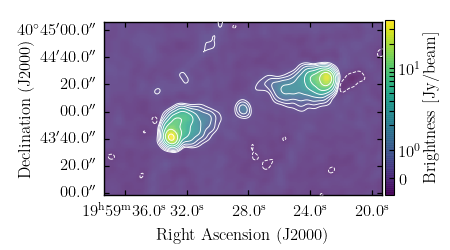

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_image.pdf


In [10]:
# wcs = WCS(synimghdr).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
# synimg_rms = 0.1 # Jy/beam
# cntr_levels = synimg_rms * NP.asarray([-2.5, 2.5, 5, 10, 20, 40, 80, 160, 320])
# # cntr_levels = synimg_rms * NP.asarray([-3, 3, 6, 12, 24, 48, 96, 192, 384])

# # fig = PLT.figure('projection': wcs, figsize=(4,4))
# # ax = fig.add_subplot(111)
# fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.5))
# data = synimgdata.squeeze()
# # img_CygA = ax.imshow(data, origin='lower', cmap='viridis', norm=PLTC.PowerNorm(gamma=0.5), interpolation='none', alpha=0.9)
# img_CygA = ax.imshow(data, origin='lower', cmap='viridis', norm=PLTC.SymLogNorm(linthresh=1.0, linscale=0.5), interpolation='none', alpha=0.8)
# # img_CygA = ax.imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.8)
# cntr_CygA = ax.contour(data, levels=cntr_levels, linewidths=0.67, colors='white')
# # ax.set_xlim(0, data.shape[1])
# # ax.set_ylim(0, data.shape[0])
# ax.set_xlim(25, data.shape[1]-25)
# ax.set_ylim(64, data.shape[0]-64)
# lon = ax.coords[0]
# lat = ax.coords[1]
# lon.set_major_formatter('hh:mm:ss.s')
# lat.set_major_formatter('dd:mm:ss.s')
# lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
# lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
# lon.set_ticks(number=5)
# lat.set_ticks(number=8)
# # if calind > 0:
# #     lat.set_ticklabel_visible(False)
# # ax.set_xlim(0, data.shape[1])
# # ax.set_ylim(0, data.shape[0])

# fig.subplots_adjust(hspace=0, wspace=0)
# fig.subplots_adjust(left=0.23, right=0.85, bottom=0.15, top=0.98)

# # divider = make_axes_locatable(ax)
# # cbax = divider.new_horizontal(size="5%", pad=0.1, pack_start=False)
# # fig.add_axes(cbax)
# # fig.colorbar(img_CygA, cax=cbax)

# cbax = fig.add_axes([0.855, 0.22, 0.02, 0.7]) 
# cbar = PLT.colorbar(img_CygA, cax=cbax)
# cbar.set_label('Brightness [Jy/beam]', labelpad=0, y=0.5)
# # cbax.get_yaxis().set_major_formatter(MPL.ticker.ScalarFormatter())
# # cbax.get_yaxis().set_minor_formatter(MPL.ticker.NullFormatter())
# # cbax.get_yaxis().set_major_formatter(MPL.ticker.FormatStrFormatter('%0.1f'))
# # cbax.get_yaxis().set_major_formatter(MPL.ticker.FormatStrFormatter('%0.1f'))
# # cbax.get_yaxis().set_minor_formatter(MPL.ticker.NullFormatter())
# # base=10.0, subs=(1.0,), 
# # cbax.get_yaxis().get_major_formatter().set_scientific(False)
# # cbax.get_yaxis().set_major_formatter(MPL.ticker.FuncFormatter(lambda y, _: '{:.1f}'.format(y)))

# big_ax = fig.add_subplot(111)
# big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
# big_ax.spines['right'].set_visible(False)
# big_ax.spines['top'].set_visible(False)
# big_ax.spines['left'].set_visible(False)
# big_ax.spines['bottom'].set_visible(False)
# big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# big_ax.set_xticks([])
# big_ax.set_yticks([])
# big_ax.set_xlabel('Right Ascension (J2000)', weight='medium', labelpad=10)
# big_ax.set_ylabel('Declination (J2000)', weight='medium', labelpad=50)

# # PLT.savefig(figdir+'CygA_image.pdf', bbox_inches=0)
# print(figdir+'CygA_image.pdf')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


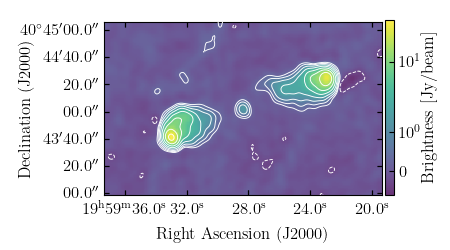

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_image.pdf


In [18]:
wcs = WCS(synimghdr).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
synimg_rms = 0.1 # Jy/beam
cntr_levels = synimg_rms * NP.asarray([-2.5, 2.5, 5, 10, 20, 40, 80, 160, 320])
# cntr_levels = synimg_rms * NP.asarray([-3, 3, 6, 12, 24, 48, 96, 192, 384])

# fig = PLT.figure('projection': wcs, figsize=(4,4))
# ax = fig.add_subplot(111)
fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.5))
data = synimgdata.squeeze()
# img_CygA = ax.imshow(data, origin='lower', cmap='viridis', norm=PLTC.PowerNorm(gamma=0.5), interpolation='none', alpha=0.9)
img_CygA = ax.imshow(data, origin='lower', cmap='viridis', norm=PLTC.SymLogNorm(linthresh=1.0, linscale=0.5), interpolation='none', alpha=0.8)
# img_CygA = ax.imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.8)
cntr_CygA = ax.contour(data, levels=cntr_levels, linewidths=0.67, colors='white')
# ax.set_xlim(0, data.shape[1])
# ax.set_ylim(0, data.shape[0])
ax.set_xlim(25, data.shape[1]-25)
ax.set_ylim(64, data.shape[0]-64)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('hh:mm:ss.s')
lat.set_major_formatter('dd:mm:ss.s')
lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
lon.set_ticks(number=5)
lat.set_ticks(number=8)
lon.set_auto_axislabel(False)
lat.set_auto_axislabel(False)
# if calind > 0:
#     lat.set_ticklabel_visible(False)
# ax.set_xlim(0, data.shape[1])
# ax.set_ylim(0, data.shape[0])

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.23, right=0.85, bottom=0.15, top=0.98)

# divider = make_axes_locatable(ax)
# cbax = divider.new_horizontal(size="5%", pad=0.1, pack_start=False)
# fig.add_axes(cbax)
# fig.colorbar(img_CygA, cax=cbax)

cbax = fig.add_axes([0.855, 0.22, 0.02, 0.7]) 
cbar = PLT.colorbar(img_CygA, cax=cbax)
cbar.set_label('Brightness [Jy/beam]', labelpad=0, y=0.5)
# cbax.get_yaxis().set_major_formatter(MPL.ticker.ScalarFormatter())
# cbax.get_yaxis().set_minor_formatter(MPL.ticker.NullFormatter())
# cbax.get_yaxis().set_major_formatter(MPL.ticker.FormatStrFormatter('%0.1f'))
# cbax.get_yaxis().set_major_formatter(MPL.ticker.FormatStrFormatter('%0.1f'))
# cbax.get_yaxis().set_minor_formatter(MPL.ticker.NullFormatter())
# base=10.0, subs=(1.0,), 
# cbax.get_yaxis().get_major_formatter().set_scientific(False)
# cbax.get_yaxis().set_major_formatter(MPL.ticker.FuncFormatter(lambda y, _: '{:.1f}'.format(y)))

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', weight='medium', labelpad=10)
big_ax.set_ylabel('Declination (J2000)', weight='medium', labelpad=50)

# PLT.savefig(figdir+'CygA_image.pdf', bbox_inches=0)
print(figdir+'CygA_image.pdf')

# Read fringe image information (CAUTION: Have to manually match the antenna pairs from the header and the filenames)

In [19]:
imgfilenames = {'ant-pairs': antpairs, 'bl-fringes': {'cal': ['E08W08RR.fits', 'E08N08RR.fits', 'N08W08RR.fits'], 'uncal': ['E08W08RRc.fits', 'E08N08RRc.fits', 'N08W08RRc.fits'], 'blerr': ['E08W08RRc.fits', 'E08N08RRc.fits', 'N08W08RRcb.fits']}, 'triad-fringes': {'cal': '3fringecal.fits', 'uncal': '3fringeuncal.fits', 'blerr': 'W08E08N08RRcb.fits'}}
imghdrs = {}
imgdata = {}
for calkey in imgfilenames['bl-fringes']:
    for fname in imgfilenames['bl-fringes'][calkey]:
        try:
            with fits.open(imgdir_CygA+fname, mode='readonly') as hdul:
                imghdrs[fname] = hdul[0].header
                imgdata[fname] = hdul[0].data
        except IOError as err:
            print(err)   

# Combine two fringes at a time

In [20]:
imgdata['two-fringes'] = {}
double_antpairs = {}
double_fringenames = {}
double_antpairs_fringenames = {}
for calkey in imgfilenames['bl-fringes']:
    imgdata['two-fringes'][calkey] = {}
    double_antpairs[calkey] = {}
    double_fringenames[calkey] = {}
    double_antpairs_fringenames[calkey] = []
    for fnamei,fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        fname_next = imgfilenames['bl-fringes'][calkey][(fnamei+1)%3]
        fkey_out = '{0}+{1}'.format(fname.split('.fits')[0], fname_next.split('.fits')[0])
        dbl_antpair = (imgfilenames['ant-pairs'][fnamei],imgfilenames['ant-pairs'][(fnamei+1)%3])
        print('{0} + {1} --> {2}'.format(fname, fname_next, fkey_out))
        imgdata['two-fringes'][calkey][fkey_out] = imgdata[fname] + imgdata[fname_next]
        double_fringenames[calkey][dbl_antpair] = copy.copy(fkey_out)
        double_antpairs[calkey][fkey_out] = copy.copy(dbl_antpair)
        double_antpairs_fringenames[calkey] += [(dbl_antpair, fkey_out)]
print(double_antpairs)
print(double_fringenames)
print(double_antpairs_fringenames)

E08W08RR.fits + E08N08RR.fits --> E08W08RR+E08N08RR
E08N08RR.fits + N08W08RR.fits --> E08N08RR+N08W08RR
N08W08RR.fits + E08W08RR.fits --> N08W08RR+E08W08RR
E08W08RRc.fits + E08N08RRc.fits --> E08W08RRc+E08N08RRc
E08N08RRc.fits + N08W08RRc.fits --> E08N08RRc+N08W08RRc
N08W08RRc.fits + E08W08RRc.fits --> N08W08RRc+E08W08RRc
E08W08RRc.fits + E08N08RRc.fits --> E08W08RRc+E08N08RRc
E08N08RRc.fits + N08W08RRcb.fits --> E08N08RRc+N08W08RRcb
N08W08RRcb.fits + E08W08RRc.fits --> N08W08RRcb+E08W08RRc
{'cal': {'E08W08RR+E08N08RR': ((13, 23), (13, 26)), 'E08N08RR+N08W08RR': ((13, 26), (23, 26)), 'N08W08RR+E08W08RR': ((23, 26), (13, 23))}, 'uncal': {'E08W08RRc+E08N08RRc': ((13, 23), (13, 26)), 'E08N08RRc+N08W08RRc': ((13, 26), (23, 26)), 'N08W08RRc+E08W08RRc': ((23, 26), (13, 23))}, 'blerr': {'E08W08RRc+E08N08RRc': ((13, 23), (13, 26)), 'E08N08RRc+N08W08RRcb': ((13, 26), (23, 26)), 'N08W08RRcb+E08W08RRc': ((23, 26), (13, 23))}}
{'cal': {((13, 23), (13, 26)): 'E08W08RR+E08N08RR', ((13, 26), (23, 26)

# Combine all three fringes

In [21]:
for calkey in imgfilenames['triad-fringes']:
    fringes = []
    for fname in imgfilenames['bl-fringes'][calkey]:
        fringes += [imgdata[fname]]
        hdr = imghdrs[fname]
    fringes = NP.asarray(fringes)
    imgdata[imgfilenames['triad-fringes'][calkey]] = NP.sum(fringes, axis=0)
    imghdrs[imgfilenames['triad-fringes'][calkey]] = hdr

In [22]:
print(imgdata.keys())

dict_keys(['E08W08RR.fits', 'E08N08RR.fits', 'N08W08RR.fits', 'E08W08RRc.fits', 'E08N08RRc.fits', 'N08W08RRc.fits', 'N08W08RRcb.fits', 'two-fringes', '3fringecal.fits', '3fringeuncal.fits', 'W08E08N08RRcb.fits'])


In [23]:
print(imgdata['two-fringes'].keys())
print(imgdata['two-fringes']['cal'].keys())

dict_keys(['cal', 'uncal', 'blerr'])
dict_keys(['E08W08RR+E08N08RR', 'E08N08RR+N08W08RR', 'N08W08RR+E08W08RR'])


# Plot the three calibrated fringes separately for Cygnus A

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


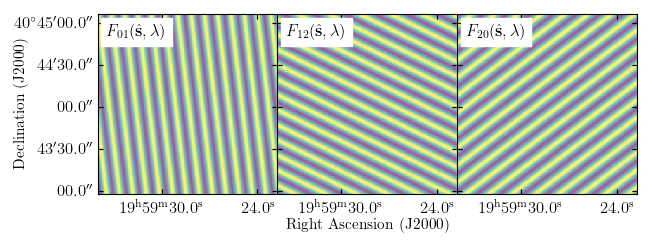

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_cal_fringes.pdf


<IPython.core.display.Javascript object>


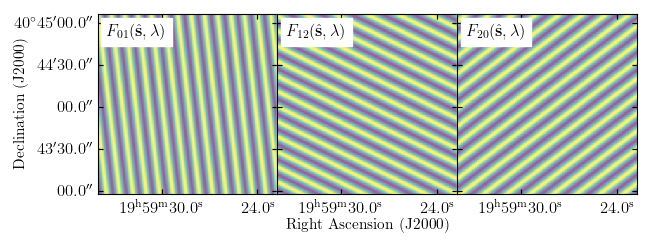

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_uncal_fringes.pdf


In [27]:
fname = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

for calkey in ['cal', 'uncal']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        wcs = WCS(imghdrs[fname]).celestial
        data = imgdata[fname].squeeze()
        center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    #     axs[fnamei].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[fnamei].transData, ls='none', marker='+', ms=8, color='black')
    #     axs[fnamei].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[fnamei].get_transform('world'), marker='+', s=16, color='black')
    #     axs[fnamei].scatter(center[0,0]-1, center[0,1], transform=axs[fnamei].get_transform('pixel'), marker='+', s=16, color='black')
#         axs[fnamei].text(center[0,0]-1, center[0,1], '+', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
#         axs[fnamei].text(center[0,0]-1, center[0,1], 'O', transform=axs[fnamei].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
        lon = axs[fnamei].coords[0]
        lat = axs[fnamei].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        lon.set_ticks(number=2)
        lon.set_auto_axislabel(False)
        lat.set_auto_axislabel(False)
        if fnamei > 0:
            lat.set_ticklabel_visible(False)

    axs[0].text(0.05, 0.95, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
    big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=50)

    PLT.savefig(figdir+'CygA_individual_{0}_fringes.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'CygA_individual_{0}_fringes.pdf'.format(calkey))

# Plot the three calibrated fringes together for Cygnus A with and without calibration

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


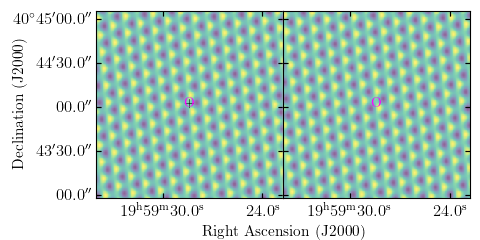

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes.pdf


In [28]:
fname = '3fringecal.fits'
wcs = WCS(imghdrs[fname]).celestial
# center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.8,2.4))

for calind, calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    wcs = WCS(imghdrs[fname]).celestial
    center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].plot(wcs.wcs.crval[0]/15.0, wcs.wcs.crval[1], transform=axs[calind].transData, ls='none', marker='+', ms=8, color='black')
#     axs[calind].scatter(wcs.wcs.crval[0], wcs.wcs.crval[1], transform=axs[calind].get_transform('world'), marker='+', s=16, color='black')
    if calkey == 'cal':
#         axs[calind].scatter(center[0,0]-1, center[0,1], transform=axs[calind].get_transform('pixel'), marker='+', s=16, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], '+', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='black')
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    if calkey == 'uncal':
        axs[calind].text(center[0,0]-1, center[0,1], 'O', transform=axs[calind].get_transform('pixel'), ha='center', va='center', fontsize=10, color='magenta')
    lon = axs[calind].coords[0]
    lat = axs[calind].coords[1]
    lon.set_major_formatter('hh:mm:ss.s')
    lat.set_major_formatter('dd:mm:ss.s')
    lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
    lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
    lon.set_ticks(number=2)
    lon.set_auto_axislabel(False)
    lat.set_auto_axislabel(False)
    if calind > 0:
        lat.set_ticklabel_visible(False)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=15)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=50)

# PLT.savefig(figdir+'CygA_all_fringes.pdf', bbox_inches=0)
print(figdir+'CygA_all_fringes.pdf')

# Plot the three calibrated two-fringe combinations for Cygnus A

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


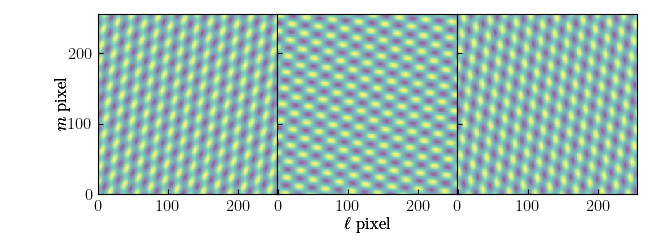

0 E08W08RR+E08N08RR
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_cal_two-fringes-E08W08RR+E08N08RR.pdf
1 E08N08RR+N08W08RR
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_cal_two-fringes-E08N08RR+N08W08RR.pdf
2 N08W08RR+E08W08RR
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_cal_two-fringes-N08W08RR+E08W08RR.pdf


<IPython.core.display.Javascript object>


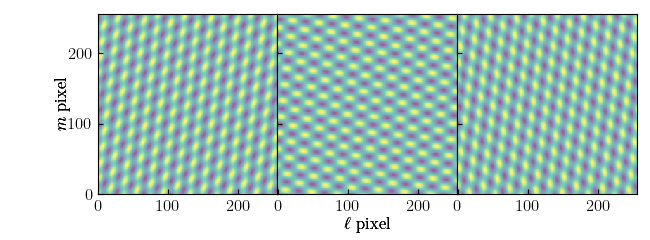

0 E08W08RRc+E08N08RRc
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_uncal_two-fringes-E08W08RRc+E08N08RRc.pdf
1 E08N08RRc+N08W08RRc
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_uncal_two-fringes-E08N08RRc+N08W08RRc.pdf
2 N08W08RRc+E08W08RRc
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_uncal_two-fringes-N08W08RRc+E08W08RRc.pdf


<IPython.core.display.Javascript object>


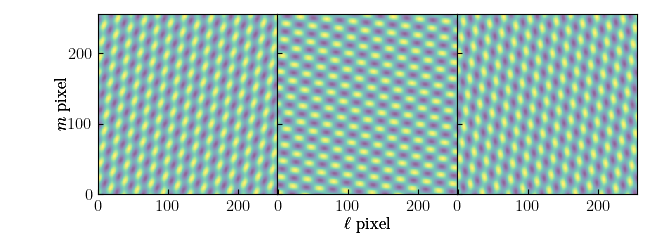

0 E08W08RRc+E08N08RRc
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_blerr_two-fringes-E08W08RRc+E08N08RRc.pdf
1 E08N08RRc+N08W08RRcb
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_blerr_two-fringes-E08N08RRc+N08W08RRcb.pdf
2 N08W08RRcb+E08W08RRc
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_blerr_two-fringes-N08W08RRcb+E08W08RRc.pdf


In [29]:
fname = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

for calkey in ['cal', 'uncal', 'blerr']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        print(fnamei, fname)

        data = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] # Flip the x-axis (second axis in this case)
        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.spines['right'].set_visible(False)
        big_ax.spines['top'].set_visible(False)
        big_ax.spines['left'].set_visible(False)
        big_ax.spines['bottom'].set_visible(False)
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$\ell$ pixel', fontsize=12, weight='medium', labelpad=10)
        big_ax.set_ylabel(r'$m$ pixel', fontsize=12, weight='medium', labelpad=20)

        # PLT.savefig(figdir+'CygA_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname), bbox_inches=0)
        print(figdir+'CygA_individual_{0}_two-fringes-{1}.pdf'.format(calkey, fname))

In [30]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 299.868150002  40.7339097243  
CRPIX : 129.0  129.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0001388888888889  0.0001388888888889  
NAXIS : 256  256


In [31]:
xy_center = {}
xy_std = {}
xy_blc = {}
xy_trc = {}
xy_center['cal'] = {'E08W08RR+E08N08RR': NP.asarray([128.0, 143.0]), 'E08N08RR+N08W08RR': NP.asarray([123.0, 141.0]), 'N08W08RR+E08W08RR': NP.asarray([128.0, 136.0])}
xy_std['cal'] = {'E08W08RR+E08N08RR': NP.asarray([2.5, 4.0]), 'E08N08RR+N08W08RR': NP.asarray([2.5, 4.0]), 'N08W08RR+E08W08RR': NP.asarray([2.5, 4.0])}
xy_blc['cal'] = {'E08W08RR+E08N08RR': NP.asarray([121, 133]), 'E08N08RR+N08W08RR': NP.asarray([113, 134]), 'N08W08RR+E08W08RR': NP.asarray([119, 125])}
xy_trc['cal'] = {'E08W08RR+E08N08RR': NP.asarray([137, 153]), 'E08N08RR+N08W08RR': NP.asarray([133, 148]), 'N08W08RR+E08W08RR': NP.asarray([137, 147])}

xy_center['uncal'] = {'E08W08RRc+E08N08RRc': NP.asarray([126.0, 125.0]), 'E08N08RRc+N08W08RRc': NP.asarray([120.0, 123.0]), 'N08W08RRc+E08W08RRc': NP.asarray([126.0, 118.0])}
xy_std['uncal'] = {'E08W08RRc+E08N08RRc': NP.asarray([2.5, 4.5]), 'E08N08RRc+N08W08RRc': NP.asarray([2.5, 4.5]), 'N08W08RRc+E08W08RRc': NP.asarray([2.5, 4.5])}
xy_blc['uncal'] = {'E08W08RRc+E08N08RRc': NP.asarray([117, 115]), 'E08N08RRc+N08W08RRc': NP.asarray([110, 116]), 'N08W08RRc+E08W08RRc': NP.asarray([117, 107])}
xy_trc['uncal'] = {'E08W08RRc+E08N08RRc': NP.asarray([135, 135]), 'E08N08RRc+N08W08RRc': NP.asarray([130, 130]), 'N08W08RRc+E08W08RRc': NP.asarray([135, 129])}

xy_center['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([126.0, 125.0]), 'E08N08RRc+N08W08RRcb': NP.asarray([131.0, 128.0]), 'N08W08RRcb+E08W08RRc': NP.asarray([127.0, 131.0])}
xy_std['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([2.5, 4.5]), 'E08N08RRc+N08W08RRcb': NP.asarray([2.5, 4.5]), 'N08W08RRcb+E08W08RRc': NP.asarray([2.5, 4.5])}
xy_blc['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([117, 115]), 'E08N08RRc+N08W08RRcb': NP.asarray([121, 121]), 'N08W08RRcb+E08W08RRc': NP.asarray([118, 120])}
xy_trc['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([135, 135]), 'E08N08RRc+N08W08RRcb': NP.asarray([141, 135]), 'N08W08RRcb+E08W08RRc': NP.asarray([136, 142])}

# xy_center['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([126.0, 125.0]), 'E08N08RRc+N08W08RRcb': NP.asarray([128.0, 114.0]), 'N08W08RRcb+E08W08RRc': NP.asarray([144.0, 118.0])}
# xy_std['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([2.5, 4.5]), 'E08N08RRc+N08W08RRcb': NP.asarray([2.5, 4.5]), 'N08W08RRcb+E08W08RRc': NP.asarray([2.5, 4.5])}
# xy_blc['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([117, 115]), 'E08N08RRc+N08W08RRcb': NP.asarray([118, 107]), 'N08W08RRcb+E08W08RRc': NP.asarray([135, 107])}
# xy_trc['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([135, 135]), 'E08N08RRc+N08W08RRcb': NP.asarray([138, 121]), 'N08W08RRcb+E08W08RRc': NP.asarray([153, 129])}

# xy_center['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([126.0, 125.0]), 'E08N08RRc+N08W08RRcb': NP.asarray([131.0, 128.0]), 'N08W08RRcb+E08W08RRc': NP.asarray([144.0, 118.0])}
# xy_std['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([2.5, 4.5]), 'E08N08RRc+N08W08RRcb': NP.asarray([2.5, 4.5]), 'N08W08RRcb+E08W08RRc': NP.asarray([2.5, 4.5])}
# xy_blc['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([117, 115]), 'E08N08RRc+N08W08RRcb': NP.asarray([121, 121]), 'N08W08RRcb+E08W08RRc': NP.asarray([135, 107])}
# xy_trc['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([135, 135]), 'E08N08RRc+N08W08RRcb': NP.asarray([141, 135]), 'N08W08RRcb+E08W08RRc': NP.asarray([153, 129])}

# xy_center['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([126.0, 125.0]), 'E08N08RRc+N08W08RRcb': NP.asarray([149.0, 114.0]), 'N08W08RRcb+E08W08RRc': NP.asarray([127.0, 131.0])}
# xy_std['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([2.5, 4.5]), 'E08N08RRc+N08W08RRcb': NP.asarray([2.5, 4.5]), 'N08W08RRcb+E08W08RRc': NP.asarray([2.5, 4.5])}
# xy_blc['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([117, 115]), 'E08N08RRc+N08W08RRcb': NP.asarray([139, 107]), 'N08W08RRcb+E08W08RRc': NP.asarray([118, 120])}
# xy_trc['blerr'] = {'E08W08RRc+E08N08RRc': NP.asarray([135, 135]), 'E08N08RRc+N08W08RRcb': NP.asarray([159, 121]), 'N08W08RRcb+E08W08RRc': NP.asarray([136, 142])}

print(xy_blc['cal'])
print(xy_trc['cal'])
print(xy_blc['uncal'])
print(xy_trc['uncal'])

{'E08W08RR+E08N08RR': array([121, 133]), 'E08N08RR+N08W08RR': array([113, 134]), 'N08W08RR+E08W08RR': array([119, 125])}
{'E08W08RR+E08N08RR': array([137, 153]), 'E08N08RR+N08W08RR': array([133, 148]), 'N08W08RR+E08W08RR': array([137, 147])}
{'E08W08RRc+E08N08RRc': array([117, 115]), 'E08N08RRc+N08W08RRc': array([110, 116]), 'N08W08RRc+E08W08RRc': array([117, 107])}
{'E08W08RRc+E08N08RRc': array([135, 135]), 'E08N08RRc+N08W08RRc': array([130, 130]), 'N08W08RRc+E08W08RRc': array([135, 129])}


In [32]:
astropy_lmfit_output = {}
astropy_lmfitter = fitting.LevMarLSQFitter()

for calkey in ['cal', 'uncal', 'blerr']:
    astropy_lmfit_output[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        print(fname)
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        g2d_model = models.Gaussian2D(x_mean=xy_center[calkey][fname][0], y_mean=xy_center[calkey][fname][1], x_stddev=xy_std[calkey][fname][0], y_stddev=xy_std[calkey][fname][1], theta=0.0)
        g2p = astropy_lmfitter(g2d_model, xgrid, ygrid, data_subset)
        astropy_lmfit_output[calkey][fname] = {}
        astropy_lmfit_output[calkey][fname]['data'] = NP.copy(data_subset)
        astropy_lmfit_output[calkey][fname]['parameters'] = {'amplitude': g2p.amplitude.value, 'x_center': g2p.x_mean.value, 'y_center': g2p.y_mean.value, 'x_std': g2p.x_stddev.value, 'y_std': g2p.y_stddev.value, 'theta': g2p.theta.value, }
        astropy_lmfit_output[calkey][fname]['modelfit'] = g2p(xgrid, ygrid)
        print(fname+': ', astropy_lmfit_output[calkey][fname]['parameters'])

E08W08RR+E08N08RR
E08W08RR+E08N08RR:  {'amplitude': 70.5520462801107, 'x_center': 128.52531804982513, 'y_center': 143.41898781928165, 'x_std': 2.3311233064638577, 'y_std': 5.566371561498146, 'theta': -6.605466304128}
E08N08RR+N08W08RR
E08N08RR+N08W08RR:  {'amplitude': 56.259117498899975, 'x_center': 122.1729503331415, 'y_center': 140.33361509009163, 'x_std': 4.703422021124956, 'y_std': 2.692469513536192, 'theta': 2.9397680453687394}
N08W08RR+E08W08RR
N08W08RR+E08W08RR:  {'amplitude': 75.78764723848944, 'x_center': 127.6592575044552, 'y_center': 136.30641955000317, 'x_std': 2.3907610815707643, 'y_std': 5.125365329304785, 'theta': 0.1155264613026554}
E08W08RRc+E08N08RRc
E08W08RRc+E08N08RRc:  {'amplitude': 70.79670500325881, 'x_center': 126.41308086534751, 'y_center': 125.71660230082392, 'x_std': 2.3148440683289486, 'y_std': 5.557954301066439, 'theta': -0.31592060258928695}
E08N08RRc+N08W08RRc
E08N08RRc+N08W08RRc:  {'amplitude': 56.25027407923916, 'x_center': 120.11311561949061, 'y_center

<IPython.core.display.Javascript object>


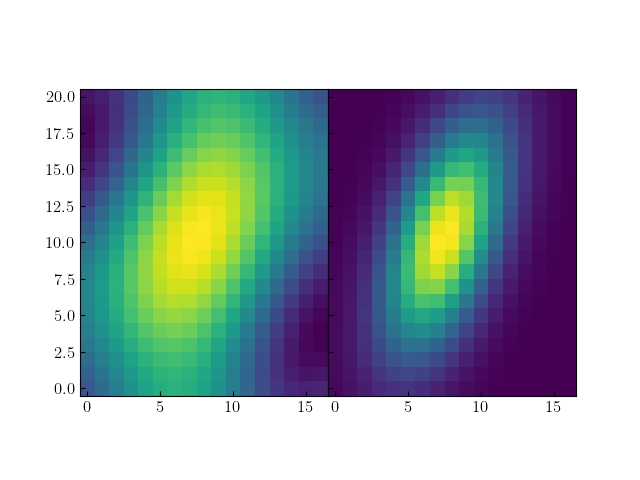

<IPython.core.display.Javascript object>


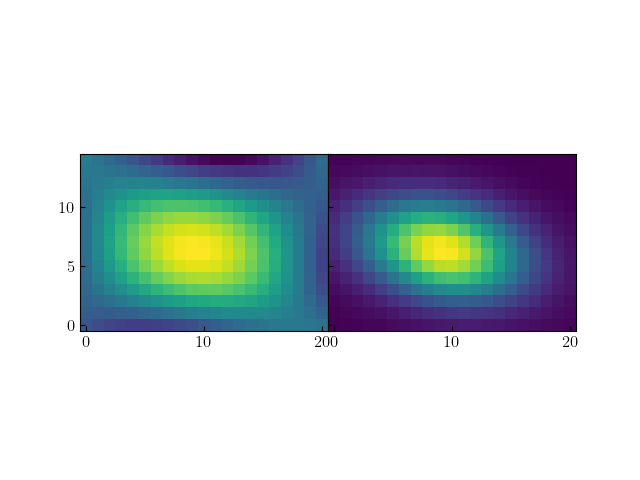

<IPython.core.display.Javascript object>


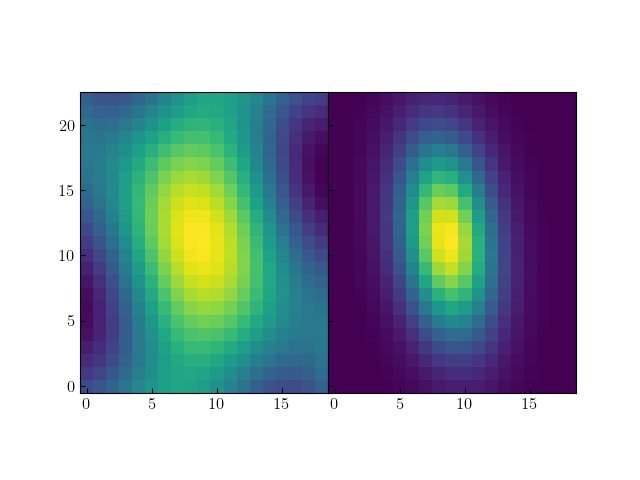

<IPython.core.display.Javascript object>


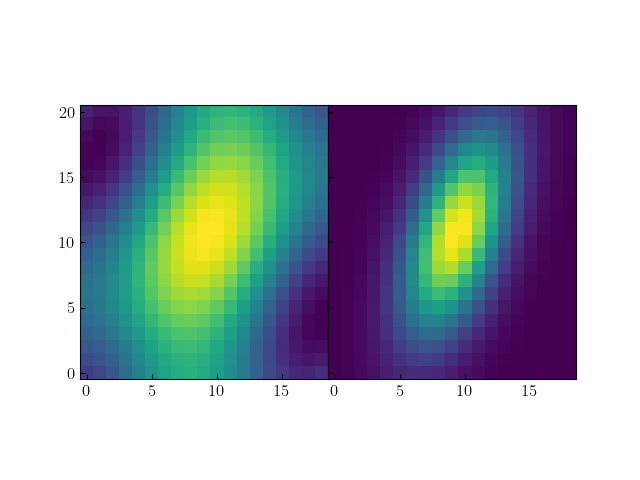

<IPython.core.display.Javascript object>


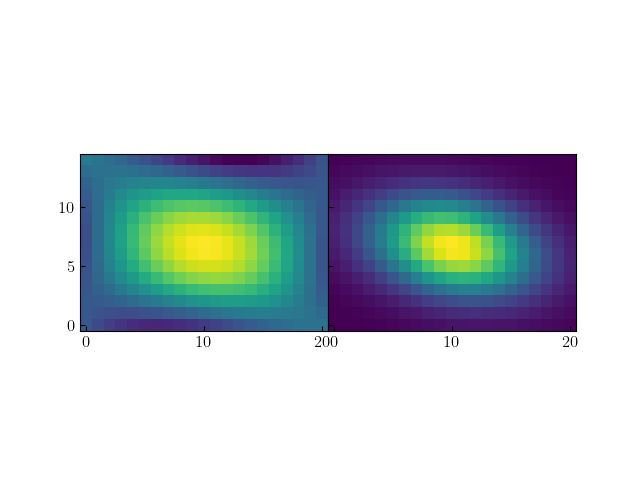

<IPython.core.display.Javascript object>


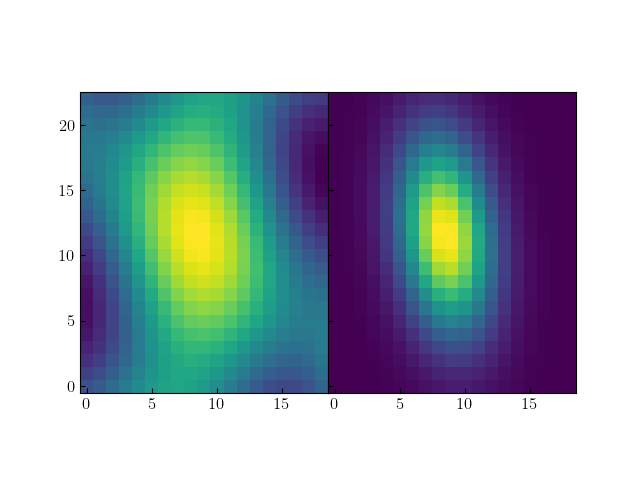

<IPython.core.display.Javascript object>


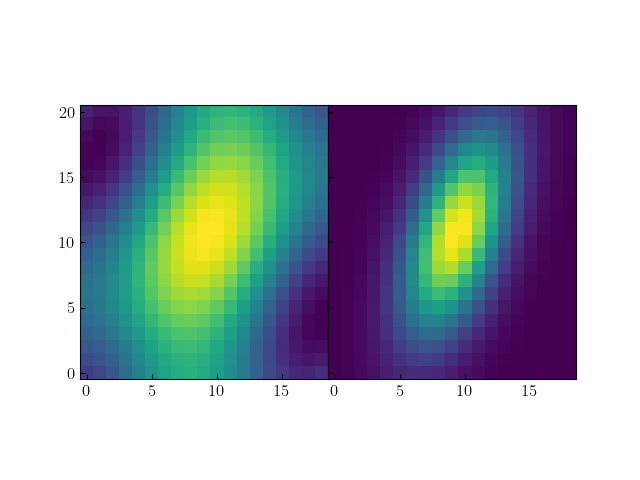

<IPython.core.display.Javascript object>


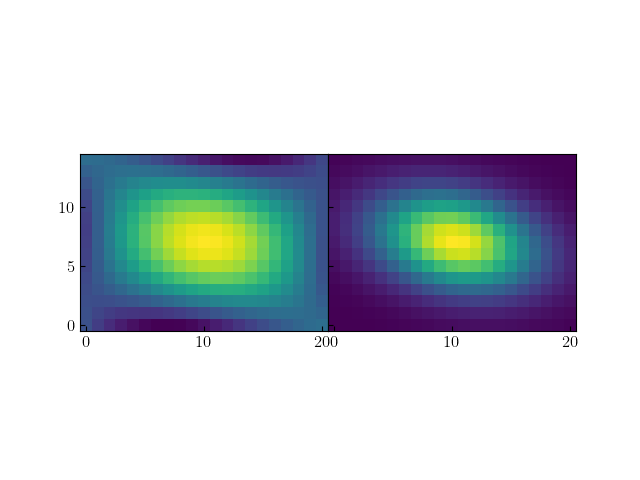

<IPython.core.display.Javascript object>


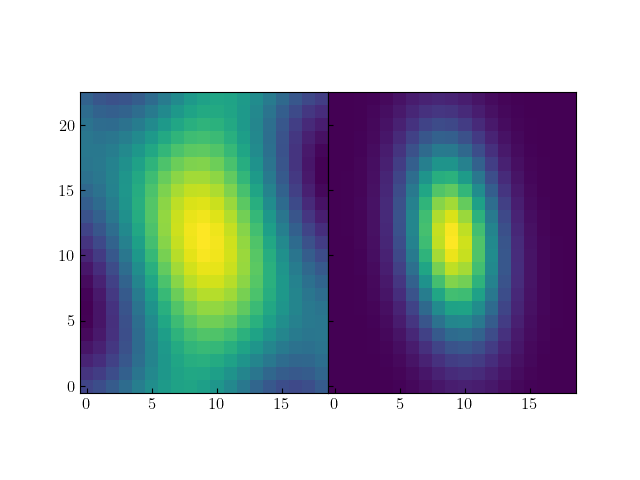

In [33]:
for calkey in ['cal', 'uncal', 'blerr']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(astropy_lmfit_output[calkey][fname]['data'], origin='lower')
        axs[1].imshow(astropy_lmfit_output[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

In [35]:
scipy_fit_output_1 = {}
for calkey in ['cal', 'uncal', 'blerr']:
    scipy_fit_output_1[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        initial_guess = (10.0, xy_center[calkey][fname][0], xy_center[calkey][fname][1], xy_std[calkey][fname][0], xy_std[calkey][fname][1], 0.0)    
        popt, pcov = OPT.curve_fit(gaussian2D_without_offset, (xgrid, ygrid), data_subset.ravel(), p0=initial_guess)
        scipy_fit_output_1[calkey][fname] = {}
        scipy_fit_output_1[calkey][fname]['data'] = NP.copy(data_subset)
        scipy_fit_output_1[calkey][fname]['parameters'] = {'amplitude': popt[0], 'x_center': popt[1], 'y_center': popt[2], 'x_std': popt[3], 'y_std': popt[4], 'theta': popt[5]}
        scipy_fit_output_1[calkey][fname]['covariance'] = NP.copy(pcov)
        scipy_fit_output_1[calkey][fname]['modelfit'] = gaussian2D_without_offset((xgrid, ygrid), scipy_fit_output_1[calkey][fname]['parameters']['amplitude'], scipy_fit_output_1[calkey][fname]['parameters']['x_center'], scipy_fit_output_1[calkey][fname]['parameters']['y_center'], scipy_fit_output_1[calkey][fname]['parameters']['x_std'], scipy_fit_output_1[calkey][fname]['parameters']['y_std'], scipy_fit_output_1[calkey][fname]['parameters']['theta']).reshape(xgrid.shape)
        print('-----{0}-----'.format(fname))
        print('    Optimum values:    ', popt)
        print('    Diagstd:    ', NP.sqrt(NP.diagonal(pcov)))
        print('    Covariance:    ', pcov[1:3,1:3])   

-----E08W08RR+E08N08RR-----
    Optimum values:     [ 70.5485749  128.52532509 143.41899341   2.33134667   5.56638915
   0.32225667]
    Diagstd:     [4.95631496 0.19645378 0.37700754 0.16116946 0.42960479 0.05095364]
    Covariance:     [[0.03859409 0.03839716]
 [0.03839716 0.14213468]]
-----E08N08RR+N08W08RR-----
    Optimum values:     [ 56.2600861  122.17294896 140.33360352   4.70341987   2.69237771
   0.20182634]
    Diagstd:     [1.61089521 0.13275673 0.07956495 0.14013491 0.07709558 0.03459523]
    Covariance:     [[ 0.01762435 -0.00239942]
 [-0.00239942  0.00633058]]
-----N08W08RR+E08W08RR-----
    Optimum values:     [ 7.57832648e+01  1.27659257e+02  1.36306423e+02  2.39103519e+00
  5.12537081e+00 -1.15491041e-01]
    Diagstd:     [5.09889056 0.16342093 0.3431306  0.15961321 0.35828958 0.05674285]
    Covariance:     [[ 0.0267064  -0.01066007]
 [-0.01066007  0.11773861]]
-----E08W08RRc+E08N08RRc-----
    Optimum values:     [ 70.79098982 126.41308385 125.71660447   2.31519191 

<IPython.core.display.Javascript object>


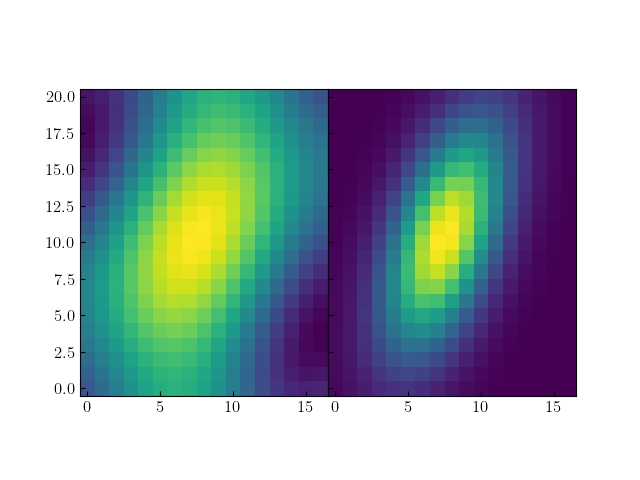

<IPython.core.display.Javascript object>


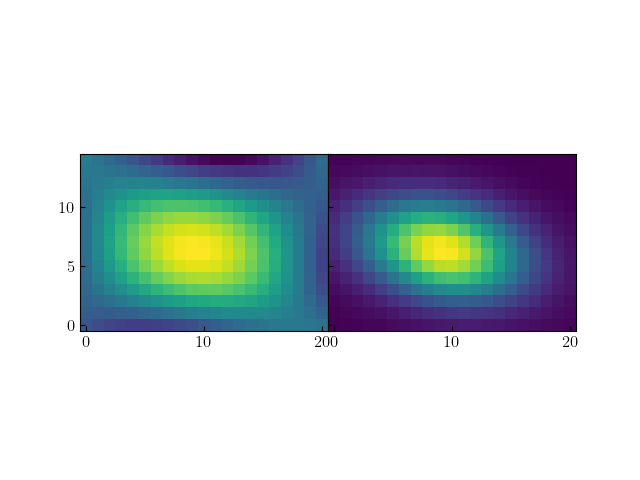

<IPython.core.display.Javascript object>


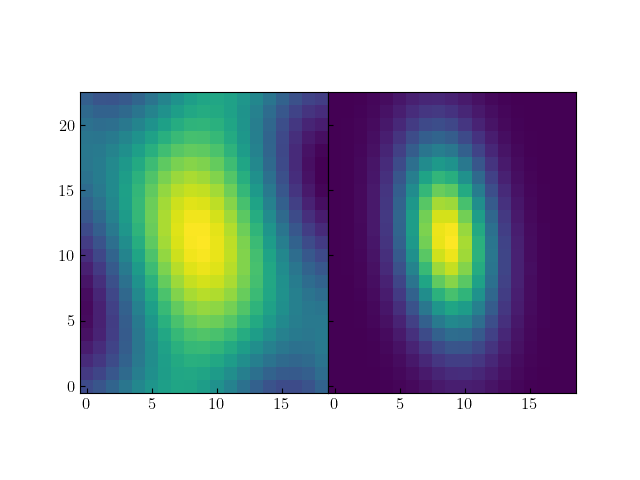

<IPython.core.display.Javascript object>


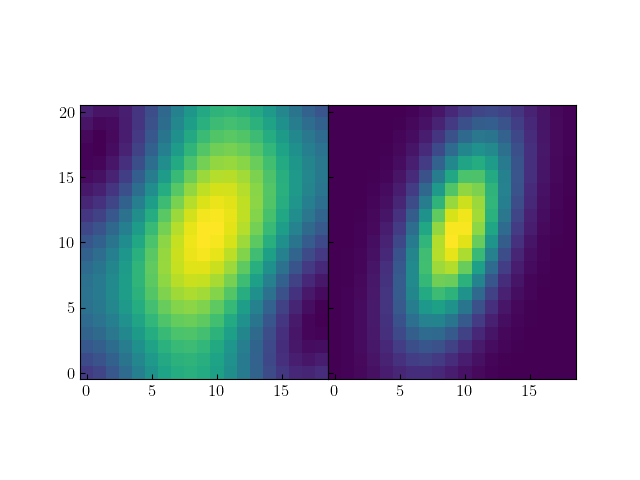

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


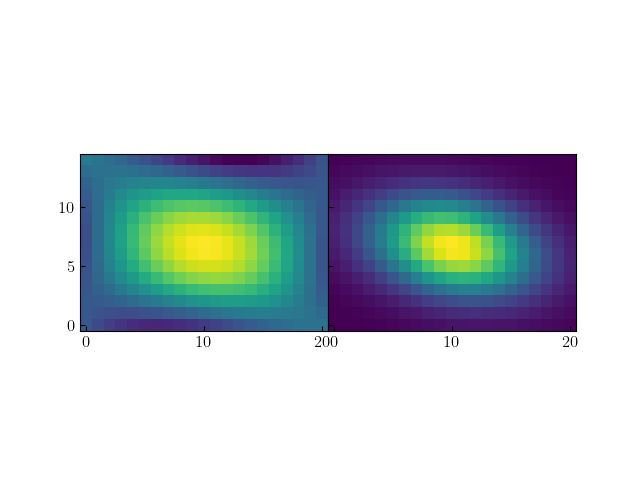

<IPython.core.display.Javascript object>


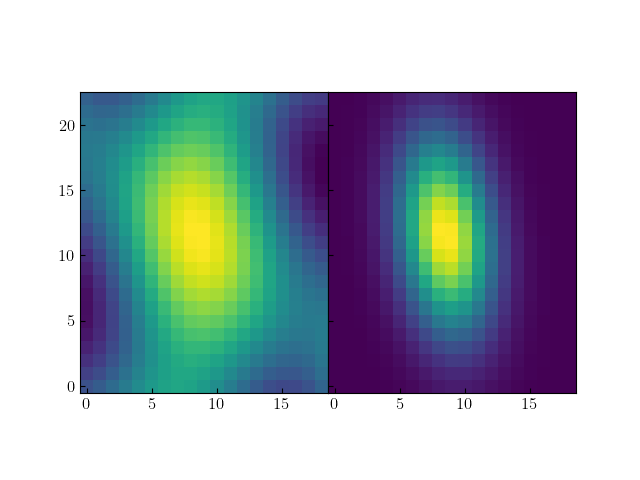

<IPython.core.display.Javascript object>


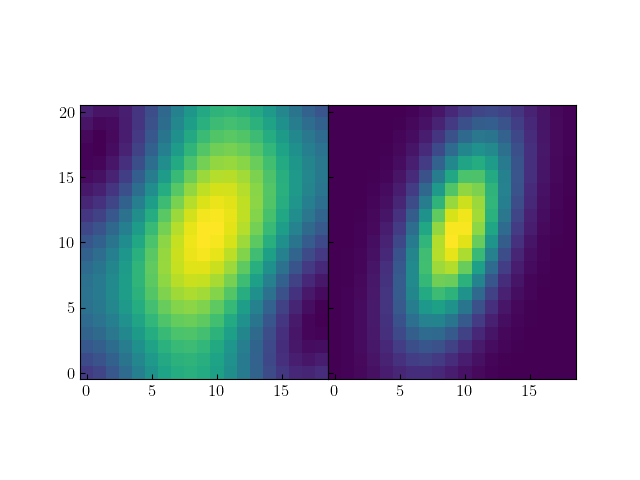

<IPython.core.display.Javascript object>


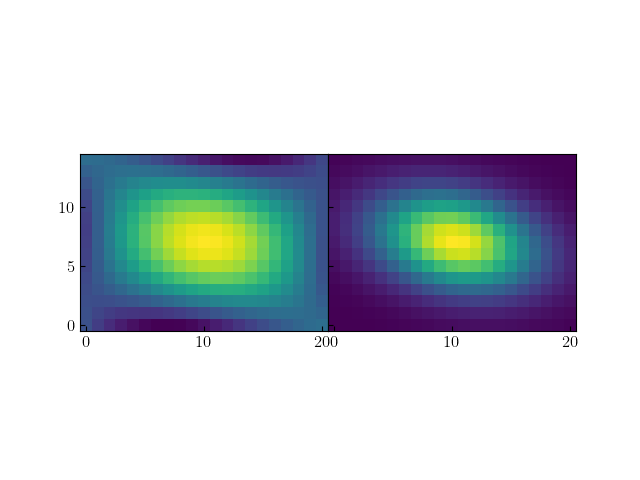

<IPython.core.display.Javascript object>


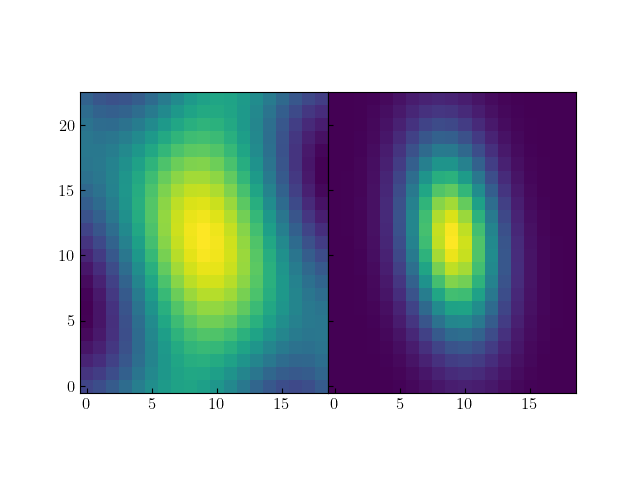

In [36]:
for calkey in ['cal', 'uncal', 'blerr']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(scipy_fit_output_1[calkey][fname]['data'], origin='lower')
        axs[1].imshow(scipy_fit_output_1[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

In [24]:
scipy_fit_output_2 = {}
for calkey in ['cal', 'uncal', 'blerr']:
    scipy_fit_output_2[calkey] = {}
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        xgrid, ygrid = NP.meshgrid(NP.arange(xy_blc[calkey][fname][0], xy_trc[calkey][fname][0]+1), NP.arange(xy_blc[calkey][fname][1], xy_trc[calkey][fname][1]+1))
        data_full = imgdata['two-fringes'][calkey][fname].squeeze()[:,::-1] 
        data_subset = data_full[xy_blc[calkey][fname][1]:xy_trc[calkey][fname][1]+1, xy_blc[calkey][fname][0]:xy_trc[calkey][fname][0]+1]
        initial_guess = (10.0, xy_center[calkey][fname][0], xy_center[calkey][fname][1], xy_std[calkey][fname][0], xy_std[calkey][fname][1], 0.0, 0.0)    
        popt, pcov = OPT.curve_fit(gaussian2D_with_offset, (xgrid, ygrid), data_subset.ravel(), p0=initial_guess)
        scipy_fit_output_2[calkey][fname] = {}
        scipy_fit_output_2[calkey][fname]['data'] = NP.copy(data_subset)
        scipy_fit_output_2[calkey][fname]['parameters'] = {'amplitude': popt[0], 'x_center': popt[1], 'y_center': popt[2], 'x_std': popt[3], 'y_std': popt[4], 'theta': popt[5], 'offset': popt[6]}
        scipy_fit_output_2[calkey][fname]['covariance'] = NP.copy(pcov)
        scipy_fit_output_2[calkey][fname]['modelfit'] = gaussian2D_with_offset((xgrid, ygrid), scipy_fit_output_2[calkey][fname]['parameters']['amplitude'], scipy_fit_output_2[calkey][fname]['parameters']['x_center'], scipy_fit_output_2[calkey][fname]['parameters']['y_center'], scipy_fit_output_2[calkey][fname]['parameters']['x_std'], scipy_fit_output_2[calkey][fname]['parameters']['y_std'], scipy_fit_output_2[calkey][fname]['parameters']['theta'], scipy_fit_output_2[calkey][fname]['parameters']['offset']).reshape(xgrid.shape)
        print('-----{0}-----'.format(fname))
        print('    Optimum values:    ', popt)
        print('    Diagstd:    ', NP.sqrt(NP.diagonal(pcov)))
        print('    Covariance:    ', pcov[1:3,1:3])

-----N08W08RR+E08W08RR-----
('    Optimum values:    ', array([115.02773653, 127.66188101, 136.2366668 ,   4.54203066,
         9.50122756,  -0.15892003, -52.35118007]))
('    Diagstd:    ', array([2.23510491, 0.04994456, 0.11808272, 0.12977148, 0.26265543,
       0.01134207, 2.46349856]))
('    Covariance:    ', array([[ 0.00249446, -0.00175834],
       [-0.00175834,  0.01394353]]))
-----E08W08RR+E08N08RR-----
('    Optimum values:    ', array([132.51682049, 128.56736639, 143.37604054,   5.03024707,
        10.96935521,   0.34605978, -72.79837669]))
('    Diagstd:    ', array([2.21662717, 0.03544658, 0.07169931, 0.09726473, 0.20977992,
       0.00682584, 2.43014563]))
('    Covariance:    ', array([[0.00125646, 0.00156105],
       [0.00156105, 0.00514079]]))
-----E08N08RR+N08W08RR-----
('    Optimum values:    ', array([ 65.80679404, 122.16102714, 140.32701176,   6.30002046,
         3.57261761,   0.21141039, -14.19034097]))
('    Diagstd:    ', array([1.13137421, 0.0846063 , 0.049030

<IPython.core.display.Javascript object>


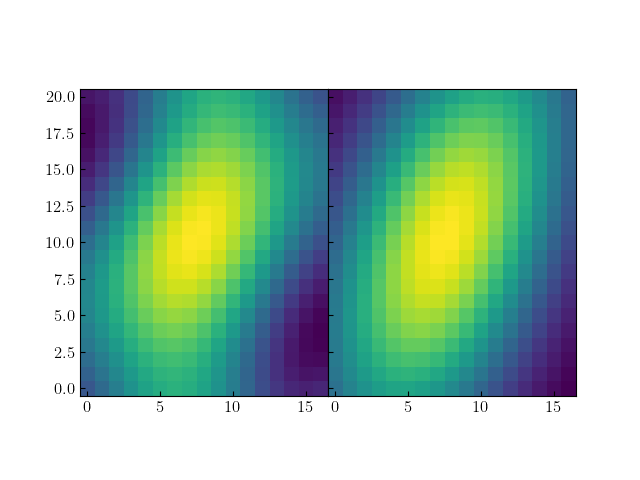

<IPython.core.display.Javascript object>


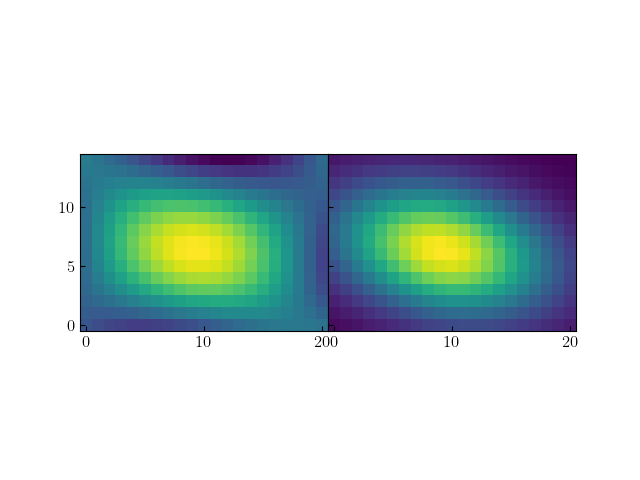

<IPython.core.display.Javascript object>


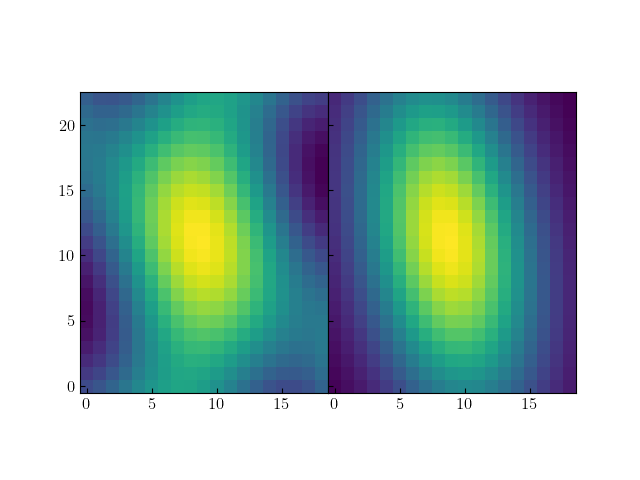

<IPython.core.display.Javascript object>


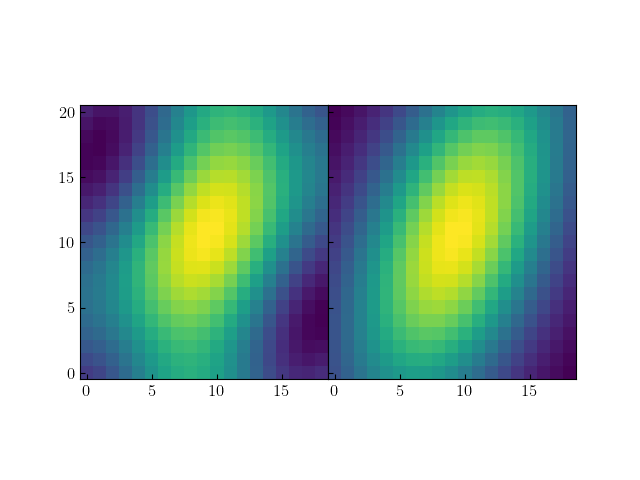

<IPython.core.display.Javascript object>


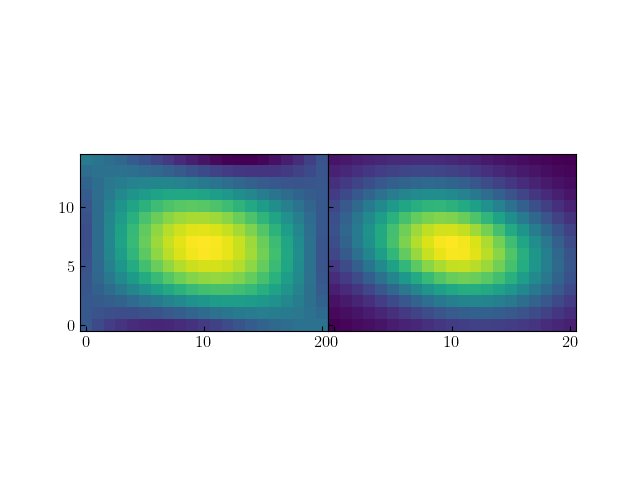

<IPython.core.display.Javascript object>


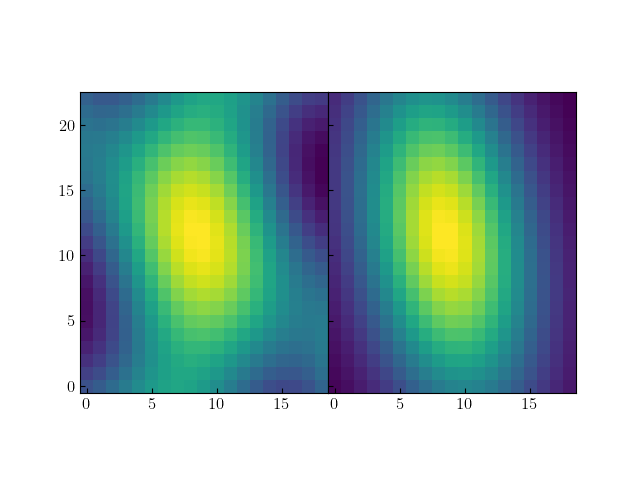

<IPython.core.display.Javascript object>


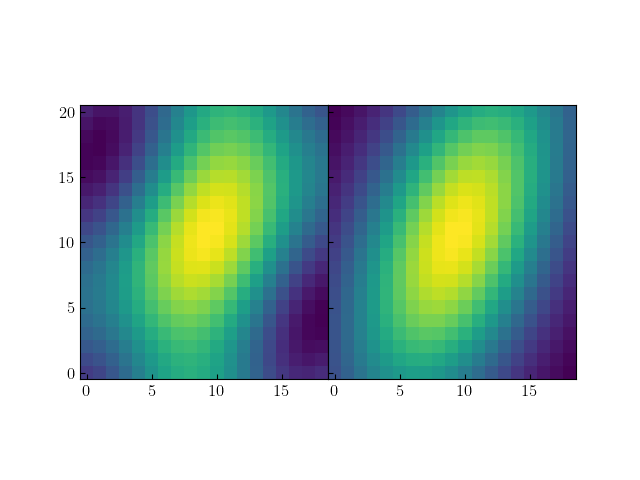

<IPython.core.display.Javascript object>


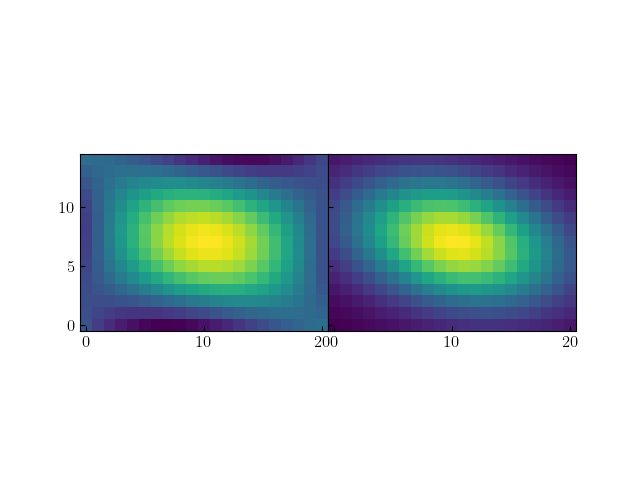

<IPython.core.display.Javascript object>


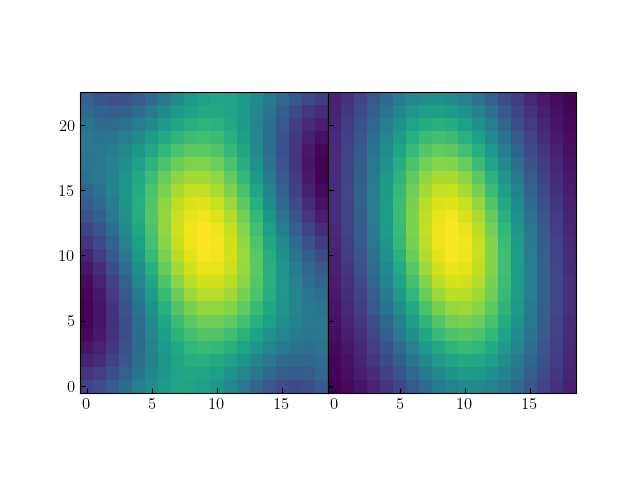

In [38]:
for calkey in ['cal', 'uncal', 'blerr']:
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True)
        axs[0].imshow(scipy_fit_output_2[calkey][fname]['data'], origin='lower')
        axs[1].imshow(scipy_fit_output_2[calkey][fname]['modelfit'], origin='lower')
        fig.subplots_adjust(hspace=0, wspace=0)

# Determine fringe NPC equations

In [40]:
points = {}
coeff_dvect_lines = {}
dvect_range_lines = {}
two_fringes_names = {}

dl_data = NP.sin(NP.radians(NP.abs(wcs.wcs.cdelt[0])))
dm_data = NP.sin(NP.radians(NP.abs(wcs.wcs.cdelt[1])))

fringe_NPC_info = {}
for calkey in ['cal', 'uncal', 'blerr']:
    points[calkey] = []
    coeff_dvect_lines[calkey] = []
    two_fringes_names[calkey] = []
    antpair_1_inds = []
    for dbl_antpair,dblfname in double_antpairs_fringenames[calkey]:
        points[calkey] += [NP.asarray([scipy_fit_output_2[calkey][dblfname]['parameters']['x_center'], scipy_fit_output_2[calkey][dblfname]['parameters']['y_center']])]
        antpair_1_inds += [antpairs.index(dbl_antpair[0])]
        print(dbl_antpair,dblfname)
    points[calkey] = NP.asarray(points[calkey])
    antpair_1_inds = NP.asarray(antpair_1_inds)
    coeff_dvect_lines[calkey] = GEOM.generate_line_from_point_and_slope(points[calkey], fringe_slopes_data[antpair_1_inds])
#     set_trace()
    dvect_range_lines[calkey] = GEOM.generate_parallel_lines_at_distance_from_line(coeff_dvect_lines[calkey][:,:2], coeff_dvect_lines[calkey][:,2], NP.degrees(pos_err[antpair_1_inds])/NP.sqrt(NP.abs(wcs.wcs.cdelt[0]*wcs.wcs.cdelt[1])))
    
    fringe_NPC_info[calkey] = {}
    for dbl_antpair,dblfname in double_antpairs_fringenames[calkey]:
        antpair1 = dbl_antpair[0]
        antpair1_ind = antpairs.index(antpair1)
        fnamei = antpair1_ind
        fname = imgfilenames['bl-fringes'][calkey][fnamei]
        fringe_NPC_info[calkey][fname] = {}
        fringe_NPC_info[calkey][fname]['equation'] = coeff_dvect_lines[calkey][fnamei]
        xvals = NP.arange(imgdata[imgfilenames['bl-fringes'][calkey][fnamei]].squeeze().shape[1])
        yvals = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], coeff_dvect_lines[calkey][fnamei][2], xvals)
        yvals_lim1 = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], dvect_range_lines[calkey][fnamei][0], xvals)
        yvals_lim2 = GEOM.get_ordinate_from_abscissa_on_line(coeff_dvect_lines[calkey][fnamei][:2], dvect_range_lines[calkey][fnamei][1], xvals)
        fringe_NPC_info[calkey][fname]['xvals'] = NP.copy(xvals)
        fringe_NPC_info[calkey][fname]['yvals'] = NP.copy(yvals)
        fringe_NPC_info[calkey][fname]['yvals_lim1'] = NP.copy(yvals_lim1)
        fringe_NPC_info[calkey][fname]['yvals_lim2'] = NP.copy(yvals_lim2)          

((13, 23), (13, 26)) E08W08RR+E08N08RR
((13, 26), (23, 26)) E08N08RR+N08W08RR
((23, 26), (13, 23)) N08W08RR+E08W08RR
((13, 23), (13, 26)) E08W08RRc+E08N08RRc
((13, 26), (23, 26)) E08N08RRc+N08W08RRc
((23, 26), (13, 23)) N08W08RRc+E08W08RRc
((13, 23), (13, 26)) E08W08RRc+E08N08RRc
((13, 26), (23, 26)) E08N08RRc+N08W08RRcb
((23, 26), (13, 23)) N08W08RRcb+E08W08RRc


In [41]:
print(type(imgdata['two-fringes'][calkey]))
print(imgfilenames['bl-fringes'][calkey])
print(two_fringes_names[calkey])
print(points[calkey].shape)
print(fringe_slopes_data.shape)

<class 'dict'>
['E08W08RRc.fits', 'E08N08RRc.fits', 'N08W08RRcb.fits']
[]
(3, 2)
(3,)


In [43]:
print(coeff_dvect_lines)
print(fringe_slopes_data)
print(yvals)
print(yvals_lim1)
print(yvals_lim2)

{'cal': array([[-8.28748608e+00,  1.00000000e+00, -9.22124218e+02],
       [-4.86839563e-01,  1.00000000e+00,  8.08541907e+01],
       [ 7.51562178e-01,  1.00000000e+00,  2.32182508e+02]]), 'uncal': array([[-8.28748608e+00,  1.00000000e+00, -9.21737129e+02],
       [-4.86839563e-01,  1.00000000e+00,  6.41443799e+01],
       [ 7.51562178e-01,  1.00000000e+00,  2.12802001e+02]]), 'blerr': array([[-8.28748608e+00,  1.00000000e+00, -9.21737129e+02],
       [-4.86839563e-01,  1.00000000e+00,  6.41533546e+01],
       [ 7.51562178e-01,  1.00000000e+00,  2.26689428e+02]])}
[ 8.287486    0.48683956 -0.7515622 ]
[226.68942829 225.93786611 225.18630393 224.43474175 223.68317957
 222.93161739 222.18005522 221.42849304 220.67693086 219.92536868
 219.1738065  218.42224433 217.67068215 216.91911997 216.16755779
 215.41599561 214.66443343 213.91287126 213.16130908 212.4097469
 211.65818472 210.90662254 210.15506037 209.40349819 208.65193601
 207.90037383 207.14881165 206.39724948 205.6456873  204.8941

# Verify that the fringe NPC equations determined align with the fringes in direction-cosine coordinates

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


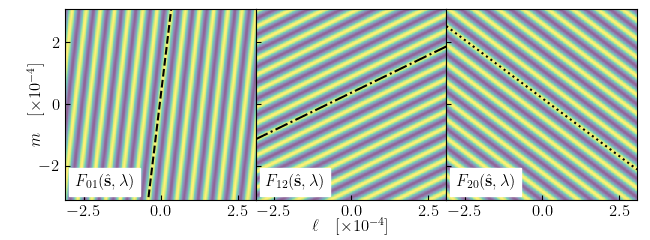

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_cal_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


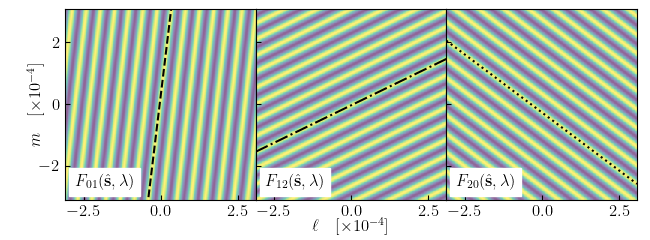

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_uncal_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


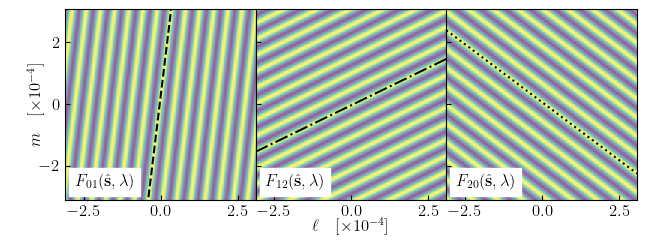

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_blerr_fringes_fitted_NPC_dircos.pdf


In [45]:
fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs[fname_init]['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs[fname_init]['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']
for calkey in ['cal', 'uncal', 'blerr']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        data = imgdata[fname].squeeze()[:,::-1]
        axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-4, (mvect_data-0.5*dm_data)/1e-4, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

        l_xvals = (fringe_NPC_info[calkey][fname]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fname]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[fnamei].plot(l_xvals/1e-4, m_yvals/1e-4, color='black', ls=ls[fnamei])
        axs[fnamei].set_xlim(lvect_data.min()/1e-4, lvect_data.max()/1e-4)
        axs[fnamei].set_ylim(mvect_data.min()/1e-4, mvect_data.max()/1e-4)

    axs[0].text(0.05, 0.05, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[0].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.05, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[1].transAxes, fontsize=12, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.05, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='bottom', transform=axs[2].transAxes, fontsize=12, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-4}]$', fontsize=12, weight='medium', labelpad=10)
    big_ax.set_ylabel(r'$m \quad [\times 10^{-4}]$', fontsize=12, weight='medium', labelpad=15)

#     PLT.savefig(figdir+'CygA_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'CygA_individual_{0}_fringes_fitted_NPC_dircos.pdf'.format(calkey))

# Verify that the fringe NPC equations determined align with the fringes in RA-Dec coordinates

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


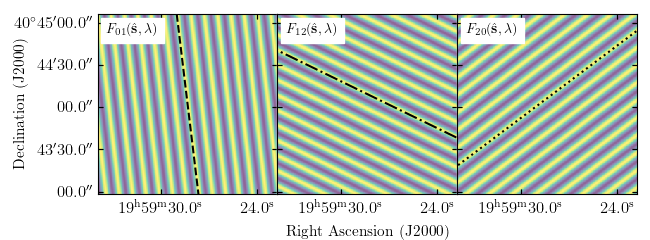

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_cal_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


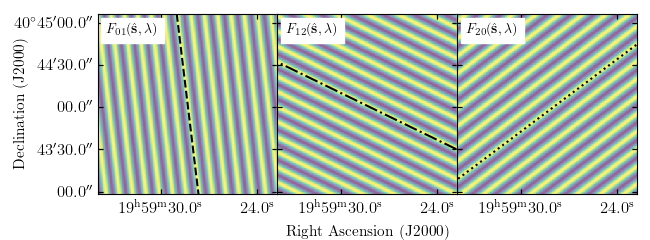

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_uncal_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


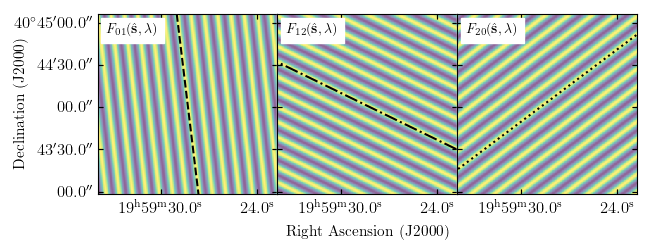

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_individual_blerr_fringes_fitted_NPC.pdf


In [47]:
fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

ls = ['--', '-.', ':']
for calkey in ['cal', 'uncal', 'blerr']:
    fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6.5,2.4))
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        data = imgdata[fname].squeeze()
#         axs[fnamei].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)

        axs[fnamei].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
        xvals = fringe_NPC_info[calkey][fname]['xvals']
        yvals = fringe_NPC_info[calkey][fname]['yvals']
        axs[fnamei].plot(xvals[::-1], yvals, color='black', ls=ls[fnamei])
        axs[fnamei].set_xlim(0, data.shape[1])
        axs[fnamei].set_ylim(0, data.shape[0])

        lon = axs[fnamei].coords[0]
        lat = axs[fnamei].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        lon.set_ticks(number=2)
        lon.set_auto_axislabel(False)
        lat.set_auto_axislabel(False)
        if fnamei > 0:
            lat.set_ticklabel_visible(False)

    axs[0].text(0.05, 0.95, r'$F_{01}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[0].transAxes, fontsize=10, color='black', backgroundcolor='white')
    axs[1].text(0.05, 0.95, r'$F_{12}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[1].transAxes, fontsize=10, color='black', backgroundcolor='white')
    axs[2].text(0.05, 0.95, r'$F_{20}(\hat{\mathbf{s}},\lambda)$', ha='left', va='top', transform=axs[2].transAxes, fontsize=10, color='black', backgroundcolor='white')

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=15)
    big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=50)

#     PLT.savefig(figdir+'CygA_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey), bbox_inches=0)
    print(figdir+'CygA_individual_{0}_fringes_fitted_NPC.pdf'.format(calkey))

# Plot three fringe images calibrated and uncalibrated with fitted NPC in direction-cosine coordinates

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


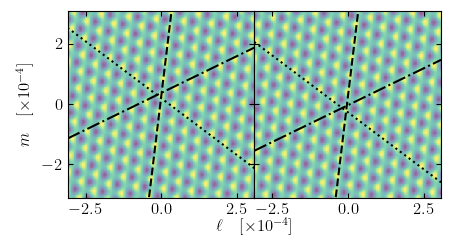

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_dircos.pdf


<IPython.core.display.Javascript object>


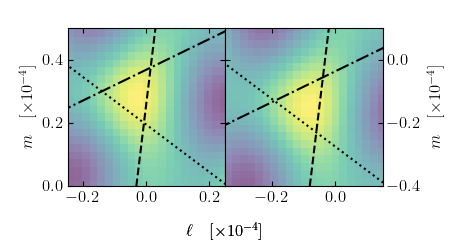

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_zoomed_dircos.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_zoomed_dircos.pdf


In [48]:
fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs[fname_init]['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs[fname_init]['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-4, (mvect_data-0.5*dm_data)/1e-4, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-4, m_yvals/1e-4, color='black', ls=ls[fnamej])
    axs[calind].set_xlim(lvect_data.min()/1e-4, lvect_data.max()/1e-4)
    axs[calind].set_ylim(mvect_data.min()/1e-4, mvect_data.max()/1e-4)
    axs[calind].tick_params(bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell \quad [\times 10^{-4}]$', fontsize=12, weight='medium', labelpad=10)
big_ax.set_ylabel(r'$m \quad [\times 10^{-4}]$', fontsize=12, weight='medium', labelpad=25)

# PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC_dircos.pdf', bbox_inches=0)
print(figdir+'CygA_all_fringes_fitted_NPC_dircos.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'aspect': 'equal'}, figsize=(4.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()[:,::-1]
    axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-4, (mvect_data-0.5*dm_data)/1e-4, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
        m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
        axs[calind].plot(l_xvals/1e-4, m_yvals/1e-4, color='black', ls=ls[fnamej])
    if calkey == 'cal': 
        axs[calind].set_xlim(-0.25, 0.25)
        axs[calind].set_ylim(0, 0.50)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-4}]$', fontsize=12, weight='medium')
    else:
        axs[calind].set_xlim(-0.35, 0.15)
        axs[calind].set_ylim(-0.40, 0.10)
        axs[calind].yaxis.tick_right()
        axs[calind].yaxis.set_label_position('right')
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True)
        axs[calind].set_ylabel(r'$m \quad [\times 10^{-4}]$', fontsize=12, weight='medium')
        
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.16, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel(r'$\ell \quad [\times 10^{-4}]$', fontsize=12, weight='medium', labelpad=15)

#     PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC_zoomed_dircos.pdf', bbox_inches=0)
    print(figdir+'CygA_all_fringes_fitted_NPC_zoomed_dircos.pdf')

# Plot three fringe images calibrated and uncalibrated with fitted NPC in RA-Dec coordinates

<IPython.core.display.Javascript object>


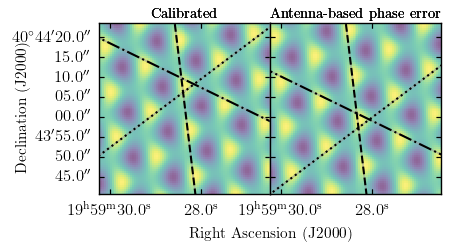

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


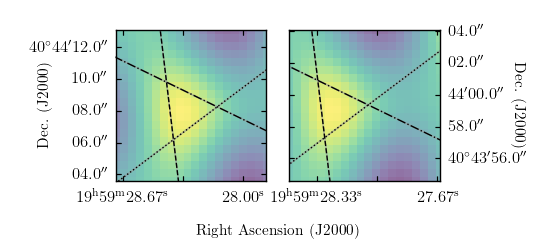

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_zoomed.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_zoomed.pdf


In [33]:
nsigma = 2

fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

calstrings = ['cal', 'uncal']
caltexts = ['Calibrated', 'Antenna-based phase error']

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.5))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
        yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
        yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
        axs[calind].fill_between(xvals[::-1], yvals_lim1_nsigma, yvals_lim2_nsigma, color='0.6', alpha=0.5)
        axs[calind].text(0.5, 1.01, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='bottom', fontsize=10.5, color='black', backgroundcolor='none')
#         axs[calind].set_xlim(0, data.shape[1])
#         axs[calind].set_ylim(0, data.shape[0])
#         axs[calind].set_xlim(42, data.shape[1]-42)
#         axs[calind].set_ylim(42, data.shape[0]-42)
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        lon.set_ticks(number=3)
        lat.set_ticks(number=7)
        lon.set_auto_axislabel(False)
        lat.set_auto_axislabel(False)
        if calind > 0:
            lat.set_ticklabel_visible(False)
#     axs[calind].set_xlim(0, data.shape[1])
#     axs[calind].set_ylim(0, data.shape[0])
#     axs[calind].set_xlim(64, data.shape[1]-64)
#     axs[calind].set_ylim(64, data.shape[0]-64)
    axs[calind].set_xlim(85, data.shape[1]-85)
    axs[calind].set_ylim(85, data.shape[0]-85)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=50)

# PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC.pdf', bbox_inches=0)
print(figdir+'CygA_all_fringes_fitted_NPC.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(5.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
        yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
        yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej], lw=1)
#         axs[calind].fill_between(xvals[::-1], yvals_lim1_1sigma, yvals_lim2_1sigma, color='0.6', alpha=0.5)
        axs[calind].fill_between(xvals[::-1], yvals_lim1_nsigma, yvals_lim2_nsigma, color='0.6', alpha=0.5)
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.ss')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))
        lon.set_ticks(number=2)
        axs[calind].set_aspect('equal')

    if calind == 0: 
#         axs[calind].set_xlim(117, 142)
#         axs[calind].set_ylim(128, 153)
        axs[calind].set_xlim(120, 139)
        axs[calind].set_ylim(131, 150)
        lon.set_ticks(number=2)
        lat.set_ticks(number=4)
        lat.set_ticklabel_position('l')
        lat.set_axislabel_position('l')
        lon.set_ticks(spacing=5*U.arcsec)
        lat.set_ticks(spacing=2*U.arcsec)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-1)
        axs[calind].yaxis.set_label_position('left')
    else:
#         axs[calind].set_xlim(118, 143)
#         axs[calind].set_ylim(110, 135)
        axs[calind].set_xlim(125, 144)
        axs[calind].set_ylim(113, 132)
        lat.set_ticklabel_position('r')
        lat.set_axislabel_position('r')
        lon.set_ticks(spacing=5*U.arcsec)
        lat.set_ticks(spacing=2*U.arcsec)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-0.5)
        
    fig.subplots_adjust(hspace=0, wspace=0.15)
    fig.subplots_adjust(left=0.21, right=0.8, bottom=0.17, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=18)

#     PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC_zoomed.pdf', bbox_inches=0)
    print(figdir+'CygA_all_fringes_fitted_NPC_zoomed.pdf')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


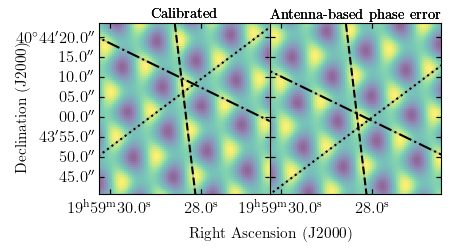

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC.pdf


<IPython.core.display.Javascript object>


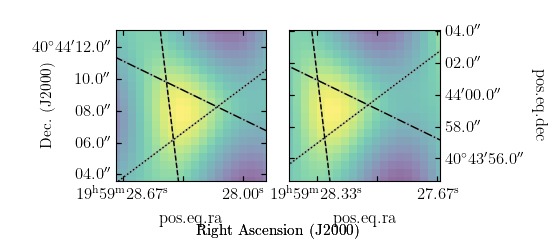

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_zoomed.pdf
/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_zoomed.pdf


In [68]:
nsigma = 2

fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

calstrings = ['cal', 'uncal']
caltexts = ['Calibrated', 'Antenna-based phase error']

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.5))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
        yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
        yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
        axs[calind].fill_between(xvals[::-1], yvals_lim1_nsigma, yvals_lim2_nsigma, color='0.6', alpha=0.5)
        axs[calind].text(0.5, 1.01, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='bottom', fontsize=10.5, color='black', backgroundcolor='none')
#         axs[calind].set_xlim(0, data.shape[1])
#         axs[calind].set_ylim(0, data.shape[0])
#         axs[calind].set_xlim(42, data.shape[1]-42)
#         axs[calind].set_ylim(42, data.shape[0]-42)
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        lon.set_ticks(number=3)
        lat.set_ticks(number=7)
        lon.set_auto_axislabel(False)
        lat.set_auto_axislabel(False)
        if calind > 0:
            lat.set_ticklabel_visible(False)
#     axs[calind].set_xlim(0, data.shape[1])
#     axs[calind].set_ylim(0, data.shape[0])
#     axs[calind].set_xlim(64, data.shape[1]-64)
#     axs[calind].set_ylim(64, data.shape[0]-64)
    axs[calind].set_xlim(85, data.shape[1]-85)
    axs[calind].set_ylim(85, data.shape[0]-85)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=50)

# PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC.pdf', bbox_inches=0)
print(figdir+'CygA_all_fringes_fitted_NPC.pdf')

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=False, sharey=False, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(5.5,2.4))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
#     axs[calind].pcolorfast((lvect_data-0.5*dl_data)/1e-6, (mvect_data-0.5*dm_data)/1e-6, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
        yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
        yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej], lw=1)
#         axs[calind].fill_between(xvals[::-1], yvals_lim1_1sigma, yvals_lim2_1sigma, color='0.6', alpha=0.5)
        axs[calind].fill_between(xvals[::-1], yvals_lim1_nsigma, yvals_lim2_nsigma, color='0.6', alpha=0.5)
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.ss')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))
        lon.set_ticks(number=2)
        axs[calind].set_aspect('equal')

    if calind == 0: 
#         axs[calind].set_xlim(117, 142)
#         axs[calind].set_ylim(128, 153)
        axs[calind].set_xlim(120, 139)
        axs[calind].set_ylim(131, 150)
        lon.set_ticks(number=2)
        lat.set_ticks(number=4)
        lat.set_ticklabel_position('l')
        lat.set_axislabel_position('l')
        lon.set_ticks(spacing=5*U.arcsec)
        lat.set_ticks(spacing=2*U.arcsec)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
#         axs[calind].tick_params(bottom=True, top=True, left=True, right=True)
        axs[calind].tick_params(axis='x', bottom=True, top=True)
        axs[calind].tick_params(axis='y', left=True, right=True)
        axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-1)
        axs[calind].yaxis.set_label_position('left')
    else:
#         axs[calind].set_xlim(118, 143)
#         axs[calind].set_ylim(110, 135)
        axs[calind].set_xlim(125, 144)
        axs[calind].set_ylim(113, 132)
        lat.set_ticklabel_position('r')
        lat.set_axislabel_position('r')
        lon.set_ticks(spacing=5*U.arcsec)
        lat.set_ticks(spacing=2*U.arcsec)
        lon.set_ticklabel(exclude_overlapping=True)
        lat.set_ticklabel(exclude_overlapping=True)
        axs[calind].set_ylabel('Dec. (J2000)', fontsize=11, weight='medium', labelpad=-0.5)
        
    fig.subplots_adjust(hspace=0, wspace=0.15)
    fig.subplots_adjust(left=0.21, right=0.8, bottom=0.17, top=0.95)

    big_ax = fig.add_subplot(111)
    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
    big_ax.spines['right'].set_visible(False)
    big_ax.spines['top'].set_visible(False)
    big_ax.spines['left'].set_visible(False)
    big_ax.spines['bottom'].set_visible(False)
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.set_xticks([])
    big_ax.set_yticks([])
    big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=18)

#     PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC_zoomed.pdf', bbox_inches=0)
    print(figdir+'CygA_all_fringes_fitted_NPC_zoomed.pdf')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


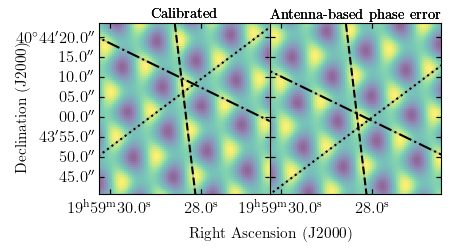

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC.pdf


In [49]:
nsigma = 2

fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

calstrings = ['cal', 'uncal']
caltexts = ['Calibrated', 'Antenna-based phase error']

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(4.5,2.5))
for calind,calkey in enumerate(['cal', 'uncal']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
        yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
        yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
        axs[calind].fill_between(xvals[::-1], yvals_lim1_nsigma, yvals_lim2_nsigma, color='0.6', alpha=0.5)
        axs[calind].text(0.5, 1.01, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='bottom', fontsize=10.5, color='black', backgroundcolor='none')
#         axs[calind].set_xlim(0, data.shape[1])
#         axs[calind].set_ylim(0, data.shape[0])
#         axs[calind].set_xlim(42, data.shape[1]-42)
#         axs[calind].set_ylim(42, data.shape[0]-42)
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        lon.set_ticks(number=3)
        lat.set_ticks(number=7)
        lon.set_auto_axislabel(False)
        lat.set_auto_axislabel(False)
        if calind > 0:
            lat.set_ticklabel_visible(False)
#     axs[calind].set_xlim(0, data.shape[1])
#     axs[calind].set_ylim(0, data.shape[0])
#     axs[calind].set_xlim(64, data.shape[1]-64)
#     axs[calind].set_ylim(64, data.shape[0]-64)
    axs[calind].set_xlim(85, data.shape[1]-85)
    axs[calind].set_ylim(85, data.shape[0]-85)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=50)

# PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC.pdf', bbox_inches=0)
print(figdir+'CygA_all_fringes_fitted_NPC.pdf')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


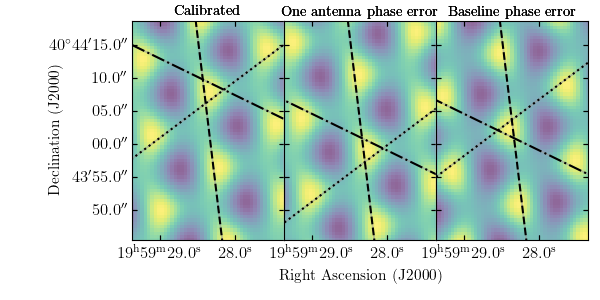

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_multipanel.pdf


In [58]:
nsigma = 2

fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

calstrings = ['cal', 'uncal', 'blerr']
caltexts = ['Calibrated', 'One antenna phase error', 'Baseline phase error']

ls = ['--', '-.', ':']

fig, axs = PLT.subplots(nrows=1, ncols=3, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(6,3))
for calind,calkey in enumerate(['cal', 'uncal', 'blerr']):
    fname = imgfilenames['triad-fringes'][calkey]
    data = imgdata[fname].squeeze()
    axs[calind].imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
    for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
        xvals = fringe_NPC_info[calkey][fn]['xvals']
        yvals = fringe_NPC_info[calkey][fn]['yvals']
        yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
        yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
        yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
        yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
        axs[calind].plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
        axs[calind].fill_between(xvals[::-1], yvals_lim1_nsigma, yvals_lim2_nsigma, color='0.6', alpha=0.5)
        axs[calind].text(0.5, 1.01, caltexts[calind], transform=axs[calind].transAxes, ha='center', va='bottom', fontsize=10.5, color='black', backgroundcolor='none')
#         axs[calind].set_xlim(0, data.shape[1])
#         axs[calind].set_ylim(0, data.shape[0])
#         axs[calind].set_xlim(42, data.shape[1]-42)
#         axs[calind].set_ylim(42, data.shape[0]-42)
        lon = axs[calind].coords[0]
        lat = axs[calind].coords[1]
        lon.set_major_formatter('hh:mm:ss.s')
        lat.set_major_formatter('dd:mm:ss.s')
        lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
        lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
        lon.set_ticks(number=3)
        lat.set_ticks(number=7)
        lon.set_auto_axislabel(False)
        lat.set_auto_axislabel(False)
        if calind > 0:
            lat.set_ticklabel_visible(False)
#     axs[calind].set_xlim(0, data.shape[1])
#     axs[calind].set_ylim(0, data.shape[0])
#     axs[calind].set_xlim(64, data.shape[1]-64)
#     axs[calind].set_ylim(64, data.shape[0]-64)
    axs[calind].set_xlim(105, data.shape[1]-105)
    axs[calind].set_ylim(95, data.shape[0]-95)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.22, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=10)
big_ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=50)

# PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC_multipanel.pdf', bbox_inches=0)
print(figdir+'CygA_all_fringes_fitted_NPC_multipanel.pdf')


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


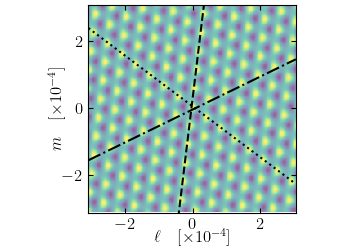

Text(0, 0.5, '$m \\quad [\\times 10^{-4}]$')

In [59]:
nsigma = 2

fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)
lvect_data = (NP.arange(imghdrs[fname_init]['NAXIS1']) - center[0,0]) * NP.abs(dl_data)
mvect_data = (NP.arange(imghdrs[fname_init]['NAXIS2']) - center[0,1]) * NP.abs(dm_data)

ls = ['--', '-.', ':']
calind = 0
calkey = 'blerr'
fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(3.4,2.5))

# for calind,calkey in enumerate(['cal', 'uncal']):
fname = imgfilenames['triad-fringes'][calkey]
data = imgdata[fname].squeeze()[:,::-1]
ax.pcolorfast((lvect_data-0.5*dl_data)/1e-4, (mvect_data-0.5*dm_data)/1e-4, data[:-1,:-1].real, cmap='viridis', alpha=0.6)
for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
    l_xvals = (fringe_NPC_info[calkey][fn]['xvals'] - center[0,0]) * NP.abs(dl_data)
    m_yvals = (fringe_NPC_info[calkey][fn]['yvals'] - center[0,1]) * NP.abs(dm_data)
    ax.plot(l_xvals/1e-4, m_yvals/1e-4, color='black', ls=ls[fnamej])
ax.set_xlim(lvect_data.min()/1e-4, lvect_data.max()/1e-4)
ax.set_ylim(mvect_data.min()/1e-4, mvect_data.max()/1e-4)
ax.tick_params(bottom=True, top=True, left=True, right=True)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.98, bottom=0.15, top=0.98)

big_ax = fig.add_subplot(111)
big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
# big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
big_ax.spines['right'].set_visible(False)
big_ax.spines['top'].set_visible(False)
big_ax.spines['left'].set_visible(False)
big_ax.spines['bottom'].set_visible(False)
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.set_xticks([])
big_ax.set_yticks([])
big_ax.set_xlabel(r'$\ell \quad [\times 10^{-4}]$', fontsize=12, weight='medium', labelpad=12)
big_ax.set_ylabel(r'$m \quad [\times 10^{-4}]$', fontsize=12, weight='medium', labelpad=-10)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


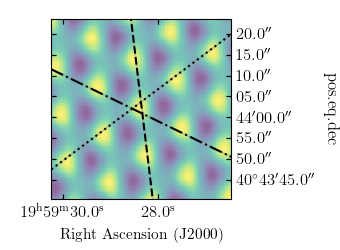

/lustre/aoc/users/nthyagar/projects/CPhaseGeom/figures/CygA_all_fringes_fitted_NPC_blerr.pdf


In [66]:
nsigma = 2

fname_init = 'E08N08RR.fits'
wcs = WCS(imghdrs[fname_init]).celestial
center = wcs.all_world2pix(NP.asarray([wcs.wcs.crval[0], wcs.wcs.crval[1]]).reshape(-1,2), 0)

ls = ['--', '-.', ':']

calind = 0
calkey = 'blerr'
fig, ax = PLT.subplots(nrows=1, ncols=1, squeeze=True, sharex=True, sharey=True, subplot_kw={'projection': wcs, 'aspect': 'equal'}, figsize=(3.4,2.5))
# for calind,calkey in enumerate(['blerr']):
fname = imgfilenames['triad-fringes'][calkey]
data = imgdata[fname].squeeze()
ax.imshow(data, origin='lower', cmap='viridis', interpolation='none', alpha=0.6)
for fnamej, fn in enumerate(imgfilenames['bl-fringes'][calkey]):
    xvals = fringe_NPC_info[calkey][fn]['xvals']
    yvals = fringe_NPC_info[calkey][fn]['yvals']
    yvals_lim1_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim1']
    yvals_lim2_1sigma = fringe_NPC_info[calkey][fn]['yvals_lim2']
    yvals_lim1_nsigma = yvals + nsigma * (yvals_lim1_1sigma - yvals)
    yvals_lim2_nsigma = yvals + nsigma * (yvals_lim2_1sigma - yvals)
    ax.plot(xvals[::-1], yvals, color='black', ls=ls[fnamej])
    ax.fill_between(xvals[::-1], yvals_lim1_nsigma, yvals_lim2_nsigma, color='0.6', alpha=0.5)
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('hh:mm:ss.s')
lat.set_major_formatter('dd:mm:ss.s')
lon.set_separator((r'$^\mathrm{h}$', r'$^\mathrm{m}$', r'$^\mathrm{s}$'))
lat.set_separator((r'$^\circ$', r'$^\prime$', r'$^{\prime\prime}$'))    
lon.set_ticks(number=3)
lat.set_ticks(number=7)
lat.set_ticklabel_position('r')
lat.set_axislabel_position('r')
ax.set_xlim(85, data.shape[1]-85)
ax.set_ylim(85, data.shape[0]-85)
ax.set_ylabel('Declination (J2000)', fontsize=11, weight='medium', labelpad=-10)
ax.set_xlabel('Right Ascension (J2000)', fontsize=11, weight='medium', labelpad=1)

fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.68, bottom=0.15, top=0.98)

# PLT.savefig(figdir+'CygA_all_fringes_fitted_NPC_blerr.pdf', bbox_inches=0)
print(figdir+'CygA_all_fringes_fitted_NPC_blerr.pdf')

In [164]:
perp_distances = {}
phase_offsets = {}
phase_uncertainties = {}
for calkey in ['cal', 'uncal', 'blerr']:
    perp_distances[calkey] = {}
    phase_offsets[calkey] = {}
    phase_uncertainties[calkey] = {}
    for fnamei, fname in enumerate(imgfilenames['bl-fringes'][calkey]):
        perp_distances[calkey][fname] = (NP.dot(coeff_dvect_lines[calkey][fnamei,:2], points[calkey][(fnamei+1)%3,:]) - coeff_dvect_lines[calkey][fnamei,2]) / NP.sqrt(NP.sum(coeff_dvect_lines[calkey][fnamei,:2]**2)) 
        phase_offsets[calkey][fname] = NP.degrees(2*NP.pi) * perp_distances[calkey][fname] * NP.sqrt(NP.sum(uvw_data[fnamei,:2]**2)) / wl0.to('m').value * dm_data
        for fnamej, fn in enumerate(imgdata['two-fringes'][calkey]):
            if fname not in fn:
                phase_uncertainties[calkey][fname] = NP.degrees(2*NP.pi) * NP.sqrt(NP.diag(scipy_fit_output_2[calkey][fn]['covariance'])[1:3]) * NP.sqrt(NP.sum(uvw_data[fnamei,:2]**2)) / wl0.to('m').value * dm_data
    print('Perpendicular offsets:    ', perp_distances[calkey])
    print('Phase offsets:    ', phase_offsets[calkey])
    print('Phase uncertainties:    ', phase_uncertainties[calkey])

('Perpendicular offsets:    ', {'E08N08RR.fits': -6.085517718258136, 'E08W08RR.fits': 5.994946881570401, 'N08W08RR.fits': 6.251231260604907})
('Phase offsets:    ', {'E08N08RR.fits': -113.57353545587834, 'E08W08RR.fits': 115.04778455481576, 'N08W08RR.fits': 113.2404657930701})
('Phase uncertainties:    ', {'E08N08RR.fits': array([1.5790006 , 0.91505699]), 'E08W08RR.fits': array([1.62366191, 0.94093896]), 'N08W08RR.fits': array([1.53263509, 0.88818741])})
('Perpendicular offsets:    ', {'N08W08RRc.fits': 6.197229773412251, 'E08N08RRc.fits': -6.0945181056795965, 'E08W08RRc.fits': 5.875965730463423})
('Phase offsets:    ', {'N08W08RRc.fits': 112.26223393629135, 'E08N08RRc.fits': -113.74150897386859, 'E08W08RRc.fits': 112.76444191491338})
('Phase uncertainties:    ', {'N08W08RRc.fits': array([0.92342459, 2.18771659]), 'E08N08RRc.fits': array([0.95136018, 2.25389973]), 'E08W08RRc.fits': array([0.97826896, 2.31765025])})
('Perpendicular offsets:    ', {'E08N08RRc.fits': 23.085010164250086, '

# Determine the area enclosed by the fringes

In [266]:
# Compute the area of the triad array elements in the aperture plane

bl_xy = NP.sqrt(NP.sum(visobj.uvw_array[:,:2]**2, axis=1)) * U.m
triad_aperture_area = herons_formula(bl_xy[0], bl_xy[1], bl_xy[2]) / wl0**2

# Consolidate the three vertices and compute the area in the image plane

fringe_vertices = {}
fringe_triangle_area = {}
closure_phase_method2 = {}

for calkey in ['cal', 'uncal']:
    tmp = []
    for fnamei, fname in enumerate(imgdata['two-fringes'][calkey]):
        tmp += [(scipy_fit_output_2[calkey][fname]['parameters']['x_center'], scipy_fit_output_2[calkey][fname]['parameters']['y_center'])]
    fringe_vertices[calkey] = NP.asarray(tmp) * NP.asarray([dl_data, dm_data]).reshape(1,-1)
    fringe_triangle_area[calkey] = GEOM.polygonArea2D(fringe_vertices[calkey], absolute=True)
    closure_phase_method2[calkey] = NP.degrees(NP.sqrt(16 * NP.pi**2 * triad_aperture_area.decompose().value * fringe_triangle_area[calkey]))
        
print(fringe_triangle_area)
print(bl_xy)
print(triad_aperture_area.decompose().value)
print(closure_phase_method2)

{'uncal': 1.235543148109503e-10, 'cal': 1.2626697358400006e-10}
[819.68726 797.1405  773.7334 ] m
197573928.842
{'uncal': 112.49320046613848, 'cal': 113.72140066320198}


In [209]:
(FCNST.c / (8 * U.GHz)).to('m')

<Quantity 0.03747406 m>

In [257]:
print(NP.degrees(phase_err))
print(NP.sqrt(NP.sum(NP.degrees(phase_err)**2)))
print(NP.sqrt(1.0**2 + 2.25**2) / NP.sqrt(3.0))

[0.12266982 0.20697154 0.17796416]
0.29925966110713437
1.4215601757693317
